In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Training History

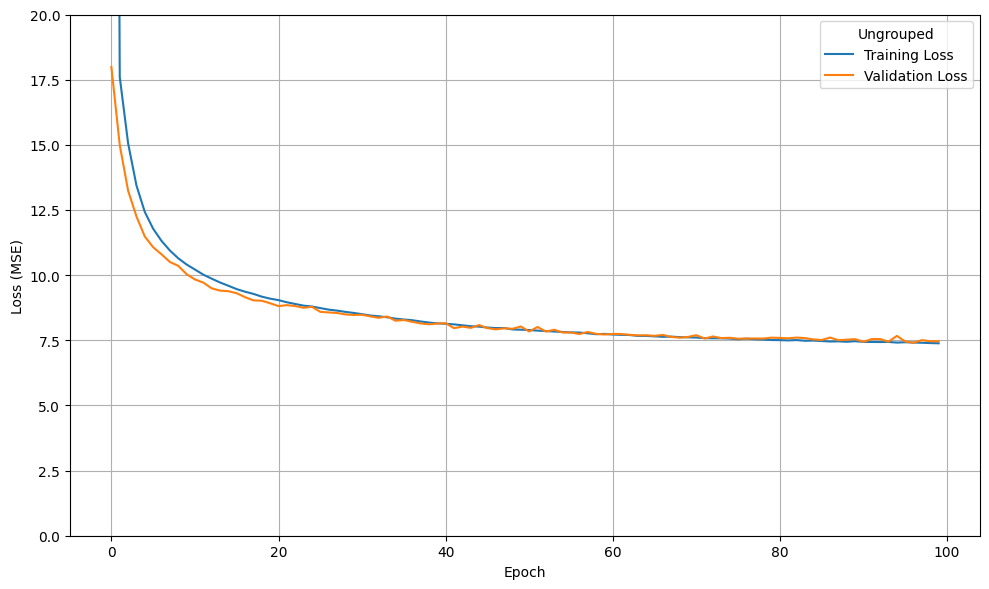

In [2]:
import pickle
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D

# Path to the history file
history_path = "/scratch/midway3/nkoebelin/mux_models_new/training_history/history_ungrouped.pkl"

# Load the training history
with open(history_path, 'rb') as f:
    history = pickle.load(f)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
#plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend(title="Ungrouped")
plt.grid(True)
plt.ylim(0,20)
plt.tight_layout()
#plt.show()
#plt.savefig("ungrouped_loss.png", dpi=300)

# Global Performance

In [14]:
#Only ungrouped 

import numpy as np
import os
from tqdm import tqdm

# --- Configuration ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
mux_name = 'ungrouped'
file_path = os.path.join(data_dir, f"saved_data_{mux_name}.npz")

# Area test ranges (name used only as a label, no saving)
area_ranges = [
    (200, 2000, 'area_200_2000'),
    (10, 50, 'area_10_50'),
    (10, 1e5, 'area_10_1e5'),
    (1e4, 1e5, 'area_1e4_1e5')
]

# Percentile function
def compute_percentiles(errors, percentiles=[68, 90, 95, 99]):
    return {f'{p}th_percentile': np.percentile(errors, p) for p in percentiles}

# Load mux pattern info
muxing_patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)
n_groups = muxing_patterns[mux_name].shape[0]

# Load ungrouped data once
with np.load(file_path) as data:
    area_test     = data['area_test']
    abs_errors    = data['abs_errors']
    radial_errors = data['radial_errors']
    pos_test      = data['pos_test']
    pos_pred      = data['pos_pred']

# Analyze each area range
all_results = {}
for area_min, area_max, label in area_ranges:
    mask = (area_test >= area_min) & (area_test <= area_max)
    if not np.any(mask):
        print(f"No events in area range {area_min}-{area_max}")
        continue

    filtered_errors = abs_errors[mask]
    filtered_radial = radial_errors[mask]
    filtered_area   = area_test[mask]
    filtered_pos_test = pos_test[mask]
    filtered_pos_pred = pos_pred[mask]

    percentiles = compute_percentiles(filtered_errors)

    result = {
        'mux_name': mux_name,
        'n_groups': n_groups,
        'mean_error': filtered_errors.mean(),
        'median_error': np.median(filtered_errors),
        'std_error': filtered_errors.std(),
        **percentiles,
        'abs_errors': filtered_errors,
        'radial_errors': filtered_radial,
        'area_test': filtered_area,
        'pos_test': filtered_pos_test,
        'pos_pred': filtered_pos_pred
    }

    all_results[label] = result

# Display summary
for label, stats in all_results.items():
    print(f"\n--- Results for area range: {label} ---")
    for k, v in stats.items():
        if isinstance(v, np.ndarray):
            print(f"{k}: array shape {v.shape}")
        elif isinstance(v, float):
            print(f"{k}: {v:.3f}")
        else:
            print(f"{k}: {v}")



--- Results for area range: area_200_2000 ---
mux_name: ungrouped
n_groups: 253
mean_error: 1.2709779739379883
median_error: 1.1077380180358887
std_error: 0.8248030543327332
68th_percentile: 1.4823397397994995
90th_percentile: 2.355362892150879
95th_percentile: 2.8188366889953613
99th_percentile: 3.8558340072631836
abs_errors: array shape (100012,)
radial_errors: array shape (100012,)
area_test: array shape (100012,)
pos_test: array shape (100012, 2)
pos_pred: array shape (100012, 2)

--- Results for area range: area_10_50 ---
mux_name: ungrouped
n_groups: 253
mean_error: 5.725613117218018
median_error: 4.73468017578125
std_error: 4.499746322631836
68th_percentile: 6.402734756469727
90th_percentile: 10.518481254577637
95th_percentile: 13.295835494995117
99th_percentile: 22.11217498779297
abs_errors: array shape (48669,)
radial_errors: array shape (48669,)
area_test: array shape (48669,)
pos_test: array shape (48669, 2)
pos_pred: array shape (48669, 2)

--- Results for area range: area

In [4]:
# All ungrouped

import numpy as np
import os
from tqdm import tqdm

# --- Configuration ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
model_names = [f'ungrouped_{i}' for i in range(1, 11)]

# Area test ranges (name used only as a label, no saving)
area_ranges = [
    (200, 2000, 'area_200_2000'),
    (10, 50, 'area_10_50'),
    (10, 1e5, 'area_10_1e5'),
    (1e4, 1e5, 'area_1e4_1e5')
]

# Function to compute percentiles
def compute_percentiles(errors, percentiles=[68, 90, 95, 99]):
    return {f'{p}th_percentile': np.percentile(errors, p) for p in percentiles}

# Load muxing pattern info (for n_groups)
muxing_patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)

# --- Main storage ---
combined_results = {}

# --- Loop over all ungrouped model variants ---
for mux_name in model_names:
    print(f"\nProcessing model: {mux_name}")
    file_path = os.path.join(data_dir, f"saved_data_{mux_name}.npz")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    with np.load(file_path) as data:
        area_test     = data['area_test']
        abs_errors    = data['abs_errors']
        radial_errors = data['radial_errors']
        pos_test      = data['pos_test']
        pos_pred      = data['pos_pred']

    # Get number of groups
    base_name = mux_name.split("_")[0]
    if base_name in muxing_patterns:
        n_groups = muxing_patterns[base_name].shape[0]
    else:
        n_groups = "unknown"

    all_results = {}
    for area_min, area_max, label in area_ranges:
        mask = (area_test >= area_min) & (area_test <= area_max)
        if not np.any(mask):
            print(f"No events in area range {area_min}-{area_max}")
            continue

        filtered_errors = abs_errors[mask]
        filtered_radial = radial_errors[mask]
        filtered_area   = area_test[mask]
        filtered_pos_test = pos_test[mask]
        filtered_pos_pred = pos_pred[mask]

        percentiles = compute_percentiles(filtered_errors)

        result = {
            'mux_name': mux_name,
            'n_groups': n_groups,
            'mean_error': filtered_errors.mean(),
            'median_error': np.median(filtered_errors),
            'std_error': filtered_errors.std(),
            **percentiles,
            'abs_errors': filtered_errors,
            'radial_errors': filtered_radial,
            'area_test': filtered_area,
            'pos_test': filtered_pos_test,
            'pos_pred': filtered_pos_pred
        }

        all_results[label] = result

    # Store in main dictionary
    combined_results[mux_name] = all_results

    # Optional: print summary
    for label, stats in all_results.items():
        print(f"\n--- Results for {mux_name} - {label} ---")
        for k, v in stats.items():
            if isinstance(v, np.ndarray):
                print(f"{k}: array shape {v.shape}")
            elif isinstance(v, float):
                print(f"{k}: {v:.3f}")
            else:
                print(f"{k}: {v}")

# Example access:
# combined_results["ungrouped_3"]["area_10_50"]["mean_error"]



Processing model: ungrouped_1

--- Results for ungrouped_1 - area_200_2000 ---
mux_name: ungrouped_1
n_groups: 253
mean_error: 1.257529854774475
median_error: 1.099039077758789
std_error: 0.8063580393791199
68th_percentile: 1.4665344953536987
90th_percentile: 2.3036179542541504
95th_percentile: 2.768563747406006
99th_percentile: 3.7639732360839844
abs_errors: array shape (100012,)
radial_errors: array shape (100012,)
area_test: array shape (100012,)
pos_test: array shape (100012, 2)
pos_pred: array shape (100012, 2)

--- Results for ungrouped_1 - area_10_50 ---
mux_name: ungrouped_1
n_groups: 253
mean_error: 5.664931297302246
median_error: 4.675757884979248
std_error: 4.474218845367432
68th_percentile: 6.272992134094238
90th_percentile: 10.427009582519531
95th_percentile: 13.244471549987793
99th_percentile: 21.998546600341797
abs_errors: array shape (48669,)
radial_errors: array shape (48669,)
area_test: array shape (48669,)
pos_test: array shape (48669, 2)
pos_pred: array shape (4866

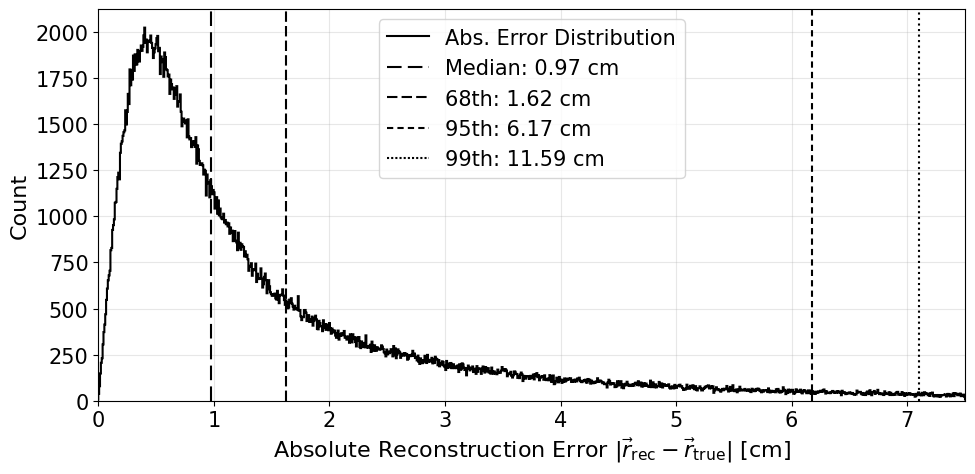

In [15]:
# single ungrouped run 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Select the result for the desired area range
selected_key = 'area_10_1e5'
result = all_results[selected_key]
abs_errors = result['abs_errors']

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 15,          # Base size for ticks
    "axes.labelsize": 16,     # x/y label size
    "axes.titlesize": 17,     # Title size
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15
})

# Define histogram bins
bins = np.linspace(0, 7.5, 1000)

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(abs_errors, bins=bins, color='black', histtype='step', linewidth=1.5)

# Define percentiles and line styles
percentile_data = {
    'Median':     (np.median(abs_errors),       (0, (7, 3))),   # long dash
    '68th':  (np.percentile(abs_errors, 68), (0, (5, 2))), # dashed
    '95th':  (np.percentile(abs_errors, 95), (0, (3, 2))), # dash-dot
    '99th':  (np.percentile(abs_errors, 99), (0, (1, 1)))  # dotted
}

# Add vertical lines and prepare custom legend handles
handles = [
    Line2D([], [], linewidth=1.5, color='black', label='Abs. Error Distribution')
]
for label, (value, linestyle) in percentile_data.items():
    plt.axvline(value, color='black', linestyle=linestyle, linewidth=1.5)
    handles.append(Line2D([], [], color='black', linestyle=linestyle, linewidth=1.5, label=f'{label}: {value:.2f} cm'))

plt.axvline(7.1, color='black', linestyle=":", linewidth=1.5)
plt.annotate('', xy=(7.45, 12500), xytext=(7.2, 12500), arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot formatting
plt.xlabel(r"Absolute Reconstruction Error $|\vec{r}_\mathrm{rec} - \vec{r}_\mathrm{true}|$ [cm]")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.xlim(0, 7.5)
plt.tight_layout()

# Legend
plt.legend(handles=handles)

#plt.show()
#plt.savefig("ungrouped_err_distr.png", dpi=300)


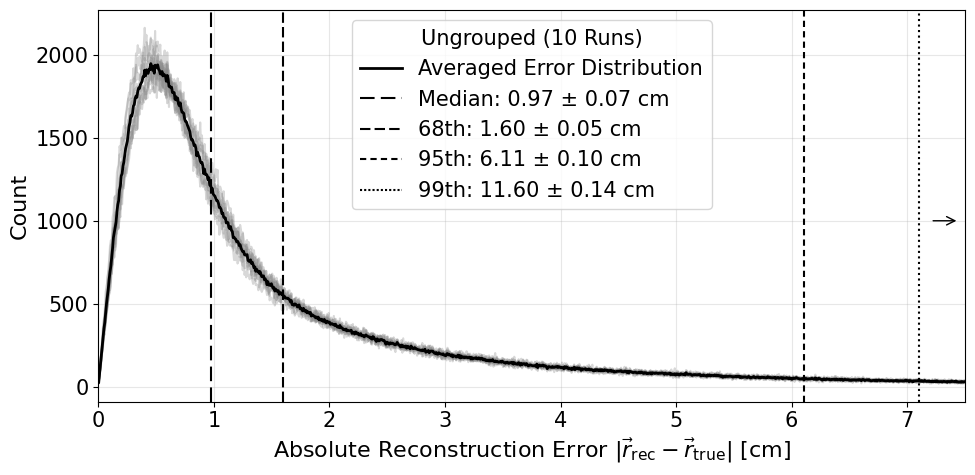

In [12]:
# 10 ungrouped runs
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 15,          # Base size for ticks
    "axes.labelsize": 16,     # x/y label size
    "axes.titlesize": 17,     # Title size
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15
})

# --- Configuration ---
area_key = 'area_10_1e5'
model_names = [f'ungrouped_{i}' for i in range(1, 11)]
bins = np.linspace(0, 7.5, 1000)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
all_histograms = []
all_percentiles = {
    'Median': [],
    '68th': [],
    '95th': [],
    '99th': []
}

# --- Collect histograms and metrics from all runs ---
for name in model_names:
    abs_errors = combined_results[name][area_key]['abs_errors']
    
    # Histogram
    hist, _ = np.histogram(abs_errors, bins=bins)
    all_histograms.append(hist)

    # Percentiles
    all_percentiles['Median'].append(np.median(abs_errors))
    all_percentiles['68th'].append(np.percentile(abs_errors, 68))
    all_percentiles['95th'].append(np.percentile(abs_errors, 95))
    all_percentiles['99th'].append(np.percentile(abs_errors, 99))

# --- Compute average histogram ---
hist_sum = np.sum(all_histograms, axis=0)
hist_avg = hist_sum / len(all_histograms)

# --- Compute average + max deviation for percentiles ---
percentile_stats = {}
for key, values in all_percentiles.items():
    values = np.array(values)
    mean = np.mean(values)
    max_dev = np.max(np.abs(values - mean))
    percentile_stats[key] = (mean, max_dev)

# --- Plot ---
plt.figure(figsize=(10, 5))

# Plot individual histograms
for hist in all_histograms:
    plt.plot(bin_centers, hist, color='gray', alpha=0.3)

# Plot average histogram
plt.plot(bin_centers, hist_avg, color='black', linewidth=2, label='Average Error Distribution')

# Add vertical percentile lines + legend entries
handles = [Line2D([], [], color='black', linewidth=2, label="Averaged Error Distribution")]
linestyles = {
    'Median': (0, (7, 3)),
    '68th': (0, (5, 2)),
    '95th': (0, (3, 2)),
    '99th': (0, (1, 1))
}

for label, (value, uncertainty) in percentile_stats.items():
    linestyle = linestyles[label]
    plt.axvline(value, color='black', linestyle=linestyle, linewidth=1.5)
    entry = f"{label}: {value:.2f} ± {uncertainty:.2f} cm"
    handles.append(Line2D([], [], color='black', linestyle=linestyle, linewidth=1.5, label=entry))

plt.axvline(7.1, color='black', linestyle=":", linewidth=1.5)
plt.annotate('', xy=(7.45, 1000), xytext=(7.2, 1000), arrowprops=dict(arrowstyle='->', color='black', lw=1))

# --- Formatting ---
plt.xlabel(r"Absolute Reconstruction Error $|\vec{r}_\mathrm{rec} - \vec{r}_\mathrm{true}|$ [cm]")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.xlim(0, 7.5)
plt.legend(title="Ungrouped (10 Runs)", handles=handles)
plt.tight_layout()
plt.savefig("ungrouped_err_distr_averaged.png", dpi=300)
plt.show()


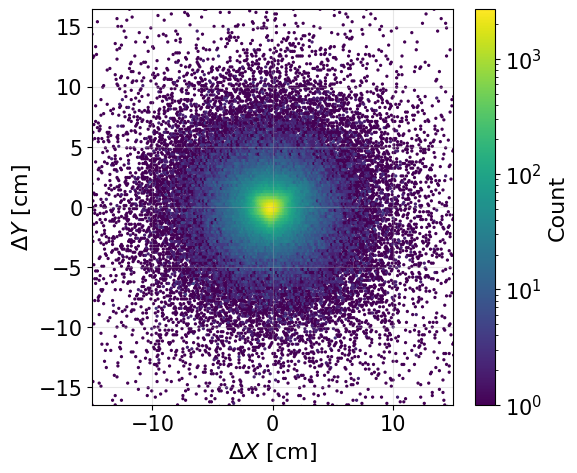

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Choose the area range key
selected_key = 'area_10_1e5'  # Change if needed
result = all_results[selected_key]

# Get predicted and true positions
pos_test = result['pos_test']
pos_pred = result['pos_pred']

# Compute x and y errors
delta_x = pos_pred[:, 0] - pos_test[:, 0]
delta_y = pos_pred[:, 1] - pos_test[:, 1]

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 15,          # Base size for ticks
    "axes.labelsize": 16,     # x/y label size
    "axes.titlesize": 17,     # Title size
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15
})

# Create figure
plt.figure(figsize=(6, 5))
hb = plt.hexbin(delta_x, delta_y, gridsize=1000, cmap='viridis', mincnt=1, norm=LogNorm())

# Colorbar and labels
cb = plt.colorbar(hb, label='Count')
#plt.title('Coordinate-wise Reconstruction Error')
plt.xlabel(r'$\Delta X$ [cm]')
plt.ylabel(r'$\Delta Y$ [cm]')
#plt.legend(title="Ungrouped", title_fontsize=15)
plt.axis("equal")
plt.grid(alpha=0.3)

# Set plot limits
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.tight_layout()
#plt.savefig("ungrouped_coord_rec_err_heatmap_full_small.png", dpi=300)
plt.show()

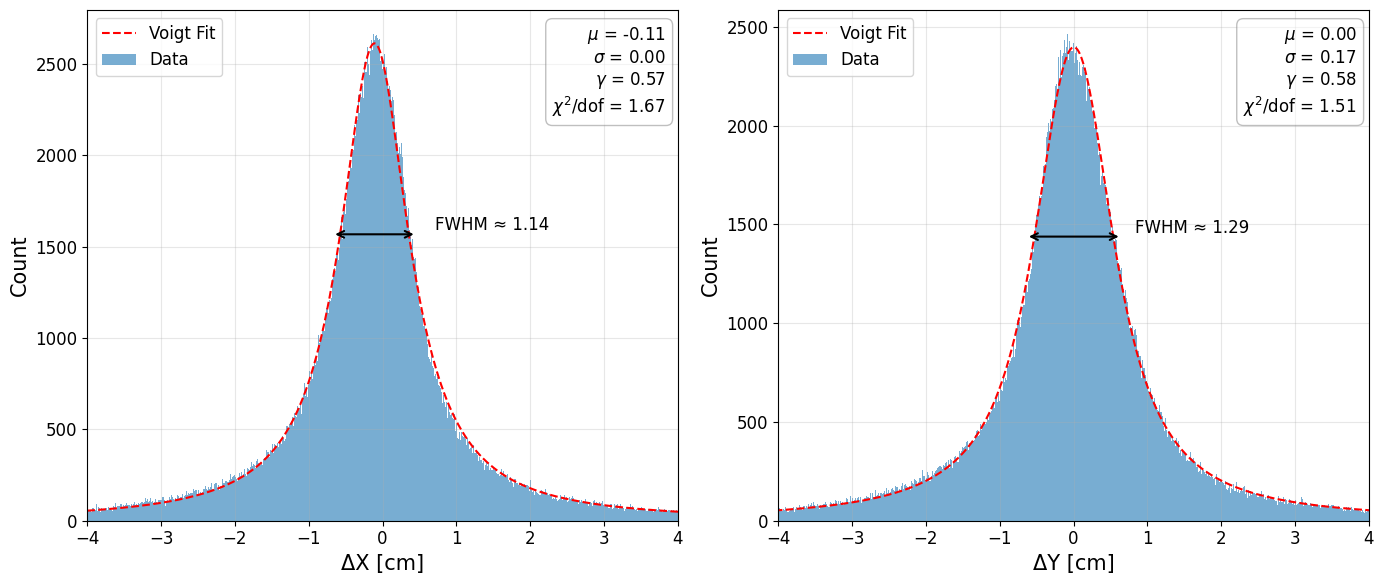

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,          # Tick labels
    "axes.labelsize": 15,     # Axis labels
    "axes.titlesize": 17,     # Plot title
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Voigt function ---
def voigt(x, x0, sigma, gamma, A):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- Load data ---
data = np.load("/scratch/midway3/nkoebelin/mux_data_new/saved_data_ungrouped.npz")
pos_test = data["pos_test"]
pos_pred = data["pos_pred"]
abs_errors = data["abs_errors"]

# --- Apply 99th percentile mask ---
threshold = np.percentile(abs_errors, 100)
mask = abs_errors < threshold

delta = pos_pred - pos_test
delta_x = delta[mask, 0]
delta_y = delta[mask, 1]

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
bins = np.linspace(-6, 6, 1000)

for ax, data_vals, label in zip(axes, [delta_x, delta_y], ["ΔX", "ΔY"]):
    counts, edges = np.histogram(data_vals, bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])
    sigma_y = np.sqrt(np.maximum(counts, 1))

    # Fit Voigt
    p0 = [0, 1, 1, max(counts)]
    popt, pcov = curve_fit(voigt, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
    x0, sigma, gamma, A = popt
    fit_vals = voigt(centers, *popt)

    # Reduced chi-squared
    residuals = counts - fit_vals
    chi2 = np.sum((residuals / sigma_y)**2)
    dof = len(centers) - len(popt)
    red_chi2 = chi2 / dof

    # FWHM approximation
    fwhm = 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2.35482 * sigma)**2)

    # Plot histogram and fit
    ax.bar(centers, counts, width=(bins[1] - bins[0]), alpha=0.6, label="Data")
    ax.plot(centers, fit_vals, 'r--', label="Voigt Fit")

    # Draw FWHM arrow
    y_arrow = voigt(x0, x0, sigma, gamma, A) * 0.6
    ax.annotate(
        "", 
        xy=(x0 - fwhm / 2, y_arrow), 
        xytext=(x0 + fwhm / 2, y_arrow), 
        arrowprops=dict(arrowstyle='<->', color='k', lw=1.5)
    )
    ax.text(x0 + 1.6, y_arrow, f"FWHM ≈ {fwhm:.2f}", ha='center', va='bottom', color='k', fontsize=12)

    # Add parameter box separately from legend
    param_text = (
        f"$\\mu$ = {x0:.2f}\n"
        f"$\\sigma$ = {sigma:.2f}\n"
        f"$\\gamma$ = {gamma:.2f}\n"
        f"$\\chi^2$/dof = {red_chi2:.2f}"
    )
    ax.text(
        0.98, 0.97, param_text,
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=12,
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha=0.5)
    )

    # Axes and layout
    ax.set_xlabel(f"{label} [cm]")
    ax.set_ylabel("Count")
    ax.set_xlim(-4, 4)
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left", fontsize=12)

plt.tight_layout()
#plt.show()
#plt.savefig("ungrouped_coord_rec_err_full_voigt.png", dpi=300)

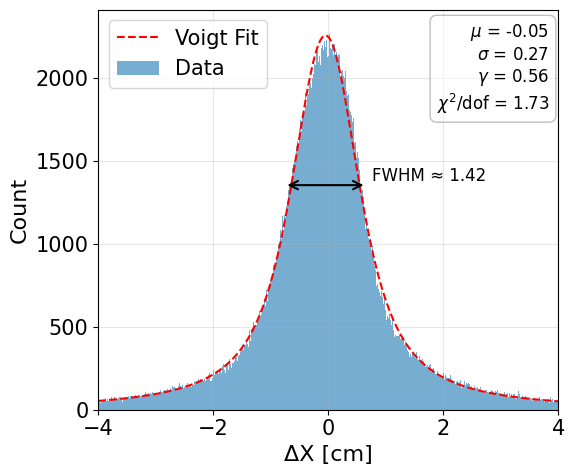

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 15,          # Base size for ticks
    "axes.labelsize": 16,     # x/y label size
    "axes.titlesize": 17,     # Title size
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15
})

# --- Voigt function ---
def voigt(x, x0, sigma, gamma, A):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- Load data ---
data = np.load("/scratch/midway3/nkoebelin/mux_data_new/saved_data_ungrouped_4.npz")
pos_test = data["pos_test"]
pos_pred = data["pos_pred"]
abs_errors = data["abs_errors"]

# --- Apply 99th percentile mask ---
threshold = np.percentile(abs_errors, 100)
mask = abs_errors < threshold

delta_x = (pos_pred - pos_test)[mask, 0]  # ΔX

# --- Plot only ΔX ---
fig, ax = plt.subplots(figsize=(6, 5))
bins = np.linspace(-6, 6, 1000)

counts, edges = np.histogram(delta_x, bins=bins)
centers = 0.5 * (edges[:-1] + edges[1:])
sigma_y = np.sqrt(np.maximum(counts, 1))

# Fit Voigt
p0 = [0, 1, 1, max(counts)]
popt, pcov = curve_fit(voigt, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
x0, sigma, gamma, A = popt
fit_vals = voigt(centers, *popt)

# Reduced chi-squared
residuals = counts - fit_vals
chi2 = np.sum((residuals / sigma_y)**2)
dof = len(centers) - len(popt)
red_chi2 = chi2 / dof

# FWHM approximation
fwhm = 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2.35482 * sigma)**2)

# Plot histogram and fit
ax.bar(centers, counts, width=(bins[1] - bins[0]), alpha=0.6, label="Data")
ax.plot(centers, fit_vals, 'r--', label="Voigt Fit")

# FWHM arrow
y_arrow = voigt(x0, x0, sigma, gamma, A) * 0.6
ax.annotate(
    "", 
    xy=(x0 - fwhm / 2, y_arrow), 
    xytext=(x0 + fwhm / 2, y_arrow), 
    arrowprops=dict(arrowstyle='<->', color='k', lw=1.5)
)
ax.text(x0 + 1.8, y_arrow, f"FWHM ≈ {fwhm:.2f}", ha='center', va='bottom', color='k', fontsize=12)

# Parameter box
param_text = (
    f"$\\mu$ = {x0:.2f}\n"
    f"$\\sigma$ = {sigma:.2f}\n"
    f"$\\gamma$ = {gamma:.2f}\n"
    f"$\\chi^2$/dof = {red_chi2:.2f}"
)
ax.text(
    0.98, 0.97, param_text,
    transform=ax.transAxes,
    ha='right', va='top',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha=0.5)
)

# Formatting
ax.set_xlabel("ΔX [cm]")
ax.set_ylabel("Count")
ax.set_xlim(-4, 4)
ax.grid(alpha=0.3)
ax.legend(loc="upper left", fontsize=15)

plt.tight_layout()
#plt.show()
#plt.savefig("ungrouped_coord_rec_err_dx_voigt.png", dpi=300)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

# --- Voigt function ---
def voigt(x, x0, sigma, gamma, A):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- Configuration ---
base_path = "/scratch/midway3/nkoebelin/mux_data_new/"
model_prefix = "saved_data_ungrouped_"
n_models = 10

# --- Storage for results ---
fit_results_x = []
fit_results_y = []
fwhms_x = []
fwhms_y = []

# --- Loop over all models ---
for i in range(1, n_models + 1):
    file_path = f"{base_path}{model_prefix}{i}.npz"
    data = np.load(file_path)

    pos_test = data["pos_test"]
    pos_pred = data["pos_pred"]
    abs_errors = data["abs_errors"]

    threshold = np.percentile(abs_errors, 100)
    mask = abs_errors < threshold

    delta = pos_pred - pos_test
    delta_x = delta[mask, 0]
    delta_y = delta[mask, 1]

    bins = np.linspace(-6, 6, 1000)

    for delta_vals, results, fwhms in zip([delta_x, delta_y], [fit_results_x, fit_results_y], [fwhms_x, fwhms_y]):
        counts, edges = np.histogram(delta_vals, bins=bins)
        centers = 0.5 * (edges[:-1] + edges[1:])
        sigma_y = np.sqrt(np.maximum(counts, 1))

        p0 = [0, 1, 1, max(counts)]
        try:
            popt, _ = curve_fit(voigt, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
            x0, sigma, gamma, A = popt
            results.append(popt)

            # FWHM approximation
            fwhm = 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2.35482 * sigma)**2)
            fwhms.append(fwhm)
        except RuntimeError:
            print(f"Fit failed for model {i}")
            results.append([np.nan] * 4)
            fwhms.append(np.nan)

# --- Convert to arrays for analysis ---
fit_results_x = np.array(fit_results_x)
fit_results_y = np.array(fit_results_y)
fwhms_x = np.array(fwhms_x)
fwhms_y = np.array(fwhms_y)

# --- Summary function ---
def summarize(name, fits, fwhms):
    print(f"\n{name} FIT RESULTS (mean ± SEM  [SD]  {{max dev}}):")
    param_names = ["μ", "σ", "γ", "A"]
    for i, pname in enumerate(param_names):
        vals = fits[:, i]
        mean = np.nanmean(vals)
        std = np.nanstd(vals)
        sem = std / np.sqrt(np.sum(~np.isnan(vals)))
        max_dev = np.nanmax(np.abs(vals - mean))
        print(f"{pname}: {mean:.3f} ± {sem:.3f}  [{std:.3f}]  {{{max_dev:.3f}}}")
    fwhm_mean = np.nanmean(fwhms)
    fwhm_std = np.nanstd(fwhms)
    fwhm_sem = fwhm_std / np.sqrt(np.sum(~np.isnan(fwhms)))
    fwhm_max_dev = np.nanmax(np.abs(fwhms - fwhm_mean))
    print(f"FWHM: {fwhm_mean:.3f} ± {fwhm_sem:.3f}  [{fwhm_std:.3f}]  {{{fwhm_max_dev:.3f}}}")

# --- Print summary ---
summarize("Δx", fit_results_x, fwhms_x)
summarize("Δy", fit_results_y, fwhms_y)



Δx FIT RESULTS (mean ± SEM  [SD]  {max dev}):
μ: 0.050 ± 0.034  [0.107]  {0.186}
σ: 0.167 ± 0.030  [0.095]  {0.167}
γ: 0.576 ± 0.004  [0.013]  {0.024}
A: 4682.387 ± 1.915  [6.055]  {13.614}
FWHM: 1.309 ± 0.036  [0.115]  {0.192}

Δy FIT RESULTS (mean ± SEM  [SD]  {max dev}):
μ: -0.043 ± 0.025  [0.078]  {0.153}
σ: 0.145 ± 0.029  [0.093]  {0.168}
γ: 0.551 ± 0.003  [0.010]  {0.018}
A: 4678.995 ± 1.757  [5.557]  {10.680}
FWHM: 1.233 ± 0.036  [0.114]  {0.269}


/scratch/local/jobs/32025650/ipykernel_2020816/3955044988.py:9: RuntimeWarning: overflow encountered in multiply
  return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))


In [19]:
combined_results["ungrouped_3"]["area_10_50"]["mean_error"]

np.float32(5.7246137)

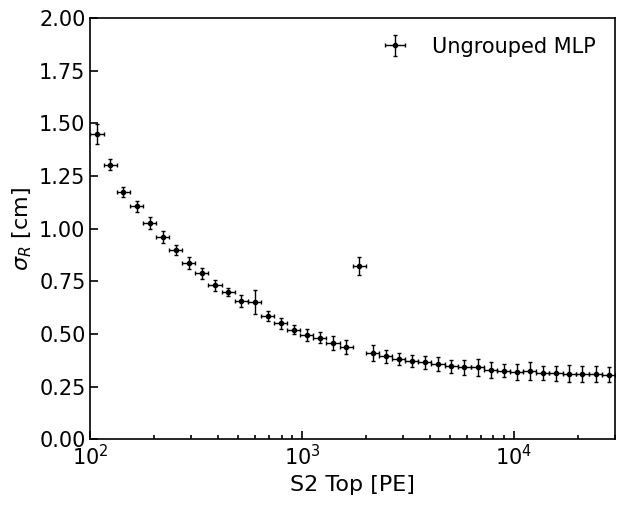

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import os
from matplotlib.ticker import ScalarFormatter

# --- Configuration ---
plt.rcParams.update({
    "font.size": 15,
    "axes.labelsize": 16,
    "axes.titlesize": 17,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": False,
    "ytick.right": False,
    "axes.linewidth": 1.2
})

data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
model_names = [f"ungrouped_{i}" for i in range(1, 11)]
n_bins = 40
main_range = (1e2, 3e4, '10–1e5 PE')
r_true_threshold = 60  # cm

# --- Binned StdDev Computation ---
def compute_binned_std(area_min, area_max):
    bins = np.logspace(np.log10(area_min), np.log10(area_max), n_bins + 1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])
    all_stds = []

    for model_name in model_names:
        path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
        if not os.path.exists(path): continue
        with np.load(path) as data:
            area = data["area_test"]
            abs_errors = data["abs_errors"]
            r_true = np.linalg.norm(data["pos_test"], axis=1)

        mask = (area >= area_min) & (area <= area_max) & (r_true < r_true_threshold)
        if not np.any(mask): continue
        std_per_bin, _, _ = binned_statistic(area[mask], abs_errors[mask], statistic='std', bins=bins)
        all_stds.append(std_per_bin)

    if not all_stds:
        return None
    all_stds = np.array(all_stds)
    mean_std = np.nanmean(all_stds, axis=0)
    max_dev_std = np.nanmax(np.abs(all_stds - mean_std[None, :]), axis=0)
    return bin_centers, bin_widths, mean_std, max_dev_std

# --- Plot ---
fig, ax = plt.subplots(figsize=(6.5, 5.3))

result = compute_binned_std(*main_range[:2])
if result:
    bin_centers, bin_widths, mean_std, max_dev_std = result
    # Manually fix the 21st data point
    #mean_std[20] = 0.5 * (mean_std[19] + mean_std[21])
    ax.errorbar(
        bin_centers, mean_std, xerr=bin_widths, yerr=max_dev_std,
        fmt='o', ms=3, capsize=1.5, elinewidth=1, color='black', label="Ungrouped MLP"
    )

# Axis settings
ax.set_xscale("log")
ax.set_xlim(1e2, 3e4)
ax.set_ylim(0, 2)

# Clean ticks
#ax.xaxis.set_major_formatter(ScalarFormatter())
#ax.ticklabel_format(axis='x', style='plain')
ax.tick_params(which='both', width=1.2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)

# Labels
ax.set_xlabel("S2 Top [PE]")
ax.set_ylabel(r"$\sigma_R$ [cm]")

# Legend
ax.legend(loc="upper right", frameon=False)

plt.tight_layout()
plt.savefig("std_vs_s2area_mlp_style.png", dpi=300)
plt.show()


# Different Energies

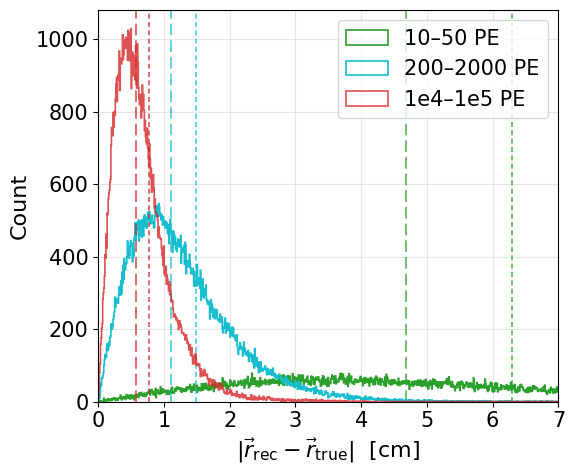

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 15,          # Base size for ticks
    "axes.labelsize": 16,     # x/y label size
    "axes.titlesize": 17,     # Title size
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15
})

# --- Selected keys and colors ---
selected_keys = {
    'area_10_50': '#2ca02c',
    'area_200_2000': '#17becf',
    'area_1e4_1e5': '#d62728'
}

label_map = {
    'area_10_50': "10–50 PE",
    'area_200_2000': "200–2000 PE",
    'area_1e4_1e5': "1e4–1e5 PE"
}

# --- Prepare figure ---
plt.figure(figsize=(6, 5))
percentile_handles = []

# Loop over keys
for key, color in selected_keys.items():
    result = all_results[key]
    abs_errors = result['abs_errors']

    # Histogram
    bins = np.linspace(0, 7.5, 900)

    if key == "area_1e4_1e5":
        plt.hist(abs_errors, bins=bins, histtype='step', linewidth=1.2, color=color, label=label_map[key], alpha=0.8)
    else:
        plt.hist(abs_errors, bins=bins, histtype='step', linewidth=1.2, color=color, label=label_map[key], alpha=1)

    # Percentile lines
    median = np.median(abs_errors)
    perc_68 = np.percentile(abs_errors, 68)
    perc_95 = np.percentile(abs_errors, 95)
    perc_99 = np.percentile(abs_errors, 99)

    # Add colored lines with no label repetition
    plt.axvline(median, color=color, linestyle=(0, (7, 3)), linewidth=1.2, alpha=0.8)
    plt.axvline(perc_68, color=color, linestyle=(0, (3, 2)), linewidth=1.2, alpha=0.8)
    #plt.axvline(perc_95, color=color, linestyle='--', linewidth=1.2, alpha=0.8)
    #plt.axvline(perc_99, color=color, linestyle='--', linewidth=1.2, alpha=0.8)

# Axis formatting
plt.xlabel(r"$|\vec{r}_\mathrm{rec} - \vec{r}_\mathrm{true}|$  [cm]")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.xlim(0, 7)
plt.tight_layout()

# Legend (one entry per key, lines already explained in caption)
plt.legend(loc="upper right")
#plt.show()
#plt.savefig("ungrouped_err_distr_multi_small.png", dpi=300)

/scratch/local/jobs/33464439/ipykernel_910254/2796997052.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.97])


Saved: /home/nkoebelin/Images/ungrouped_hitpattern_energy_ranges.png


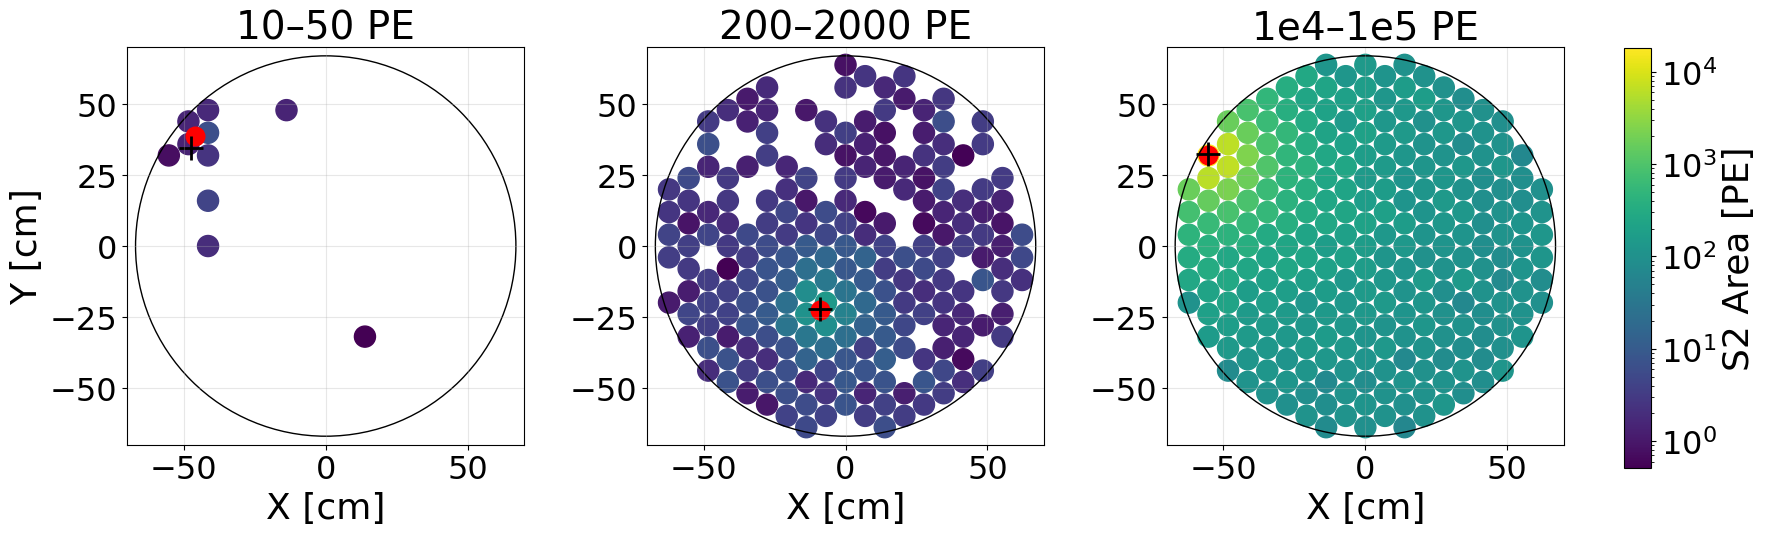

In [23]:
def plot_ungrouped_hitpatterns_by_energy(
    raw_data_path,
    base_npz_path,
    hex_geometry_file,
    idx_test_array,
    lookup_dict,
    save_image=False,
    image_dir="/home/nkoebelin/Images"
):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from matplotlib.patches import Circle
    import numpy as np
    import h5py, os

    # Load global test indices and ungrouped data
    data = np.load(os.path.join(base_npz_path, "saved_data_ungrouped.npz"))
    area_test = data["area_test"]
    pos_pred = data["pos_pred"]
    abs_errors = data["abs_errors"]

    # Energy ranges: (min, max, label)
    area_ranges = [
        (10, 50, "10–50 PE"),
        (200, 2000, "200–2000 PE"),
        (1e4, 1e5, "1e4–1e5 PE")
    ]

    # Pick one valid event index per energy range
    event_indices = []
    for area_min, area_max, _ in area_ranges:
        for i, area in enumerate(area_test):
            if area_min <= area <= area_max:
                event_indices.append(i)
                break

    assert len(event_indices) == 3, "Did not find 3 valid test events."

    # --- Font size setup ---
    plt.rcParams.update({
        "font.size": 26,
        "axes.labelsize": 26,
        "axes.titlesize": 28,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "legend.fontsize": 26
    })

    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.05)

    all_pmt_intensities = []

    # Load raw hitpatterns
    for test_idx in event_indices:
        global_idx = idx_test_array[test_idx]
        filename, local_idx = lookup_dict[global_idx]
        h5_path = os.path.join(raw_data_path, filename)

        with h5py.File(h5_path, "r") as f:
            hitpattern = f["hitpatterns"][local_idx]
            all_pmt_intensities.append(hitpattern)

    # Compute color limits
    all_values = np.concatenate(all_pmt_intensities)
    vmin = np.min(all_values[all_values > 0])
    vmax = np.max(all_values)

    # Plot
    for i, (test_idx, ax) in enumerate(zip(event_indices, axes)):
        global_idx = idx_test_array[test_idx]
        filename, local_idx = lookup_dict[global_idx]
        h5_path = os.path.join(raw_data_path, filename)

        with h5py.File(h5_path, "r") as f:
            hitpattern = f["hitpatterns"][local_idx]
            interface_x = f["interface_x"][local_idx]
            interface_y = f["interface_y"][local_idx]

        pred = pos_pred[test_idx]
        err = abs_errors[test_idx]

        ax.scatter(pmt_x_top, pmt_y_top, c=hitpattern, cmap='viridis', s=230,
                   norm=LogNorm(vmin=vmin, vmax=vmax))
        ax.scatter(interface_x, interface_y, c='red', s=180, label='MC')
        ax.scatter(pred[0], pred[1], c='k', marker='+', linewidths=2, s=300, label=f'Error = {err:.2f} cm')

        ax.add_patch(Circle((0, 0), 67, fill=False, color='k', lw=1))
        ax.set_title(area_ranges[i][2])
        ax.set_xlim(-70, 70)
        ax.set_ylim(-70, 70)
        ax.set_aspect("equal")
        ax.grid(alpha=0.3)
        ax.set_xlabel("X [cm]")
        if i == 0:
            ax.set_ylabel("Y [cm]")

    # Colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label="S2 Area [PE]")

    plt.tight_layout(rect=[0, 0, 0.91, 0.97])

    if save_image:
        os.makedirs(image_dir, exist_ok=True)
        out_path = os.path.join(image_dir, "ungrouped_hitpattern_energy_ranges.png")
        plt.savefig(out_path, dpi=300)
        print(f"Saved: {out_path}")

    #plt.tight_layout(rect=[0, 0, 0.91, 1])
    plt.show()

plot_ungrouped_hitpatterns_by_energy(
    raw_data_path="/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/",
    base_npz_path="/scratch/midway3/nkoebelin/mux_data_new",
    hex_geometry_file="hex_pattern_data.npz",
    idx_test_array=np.load("idx_test_global_area_cut.npy"),
    lookup_dict=np.load("global_index_lookup.npy", allow_pickle=True).item(),
    save_image=False
)



10–1e5 PE: 0.97 ± 0.07 cm
10–50 PE: 4.71 ± 0.08 cm
200–2000 PE: 1.10 ± 0.04 cm
1e4–1e5 PE: 0.55 ± 0.06 cm


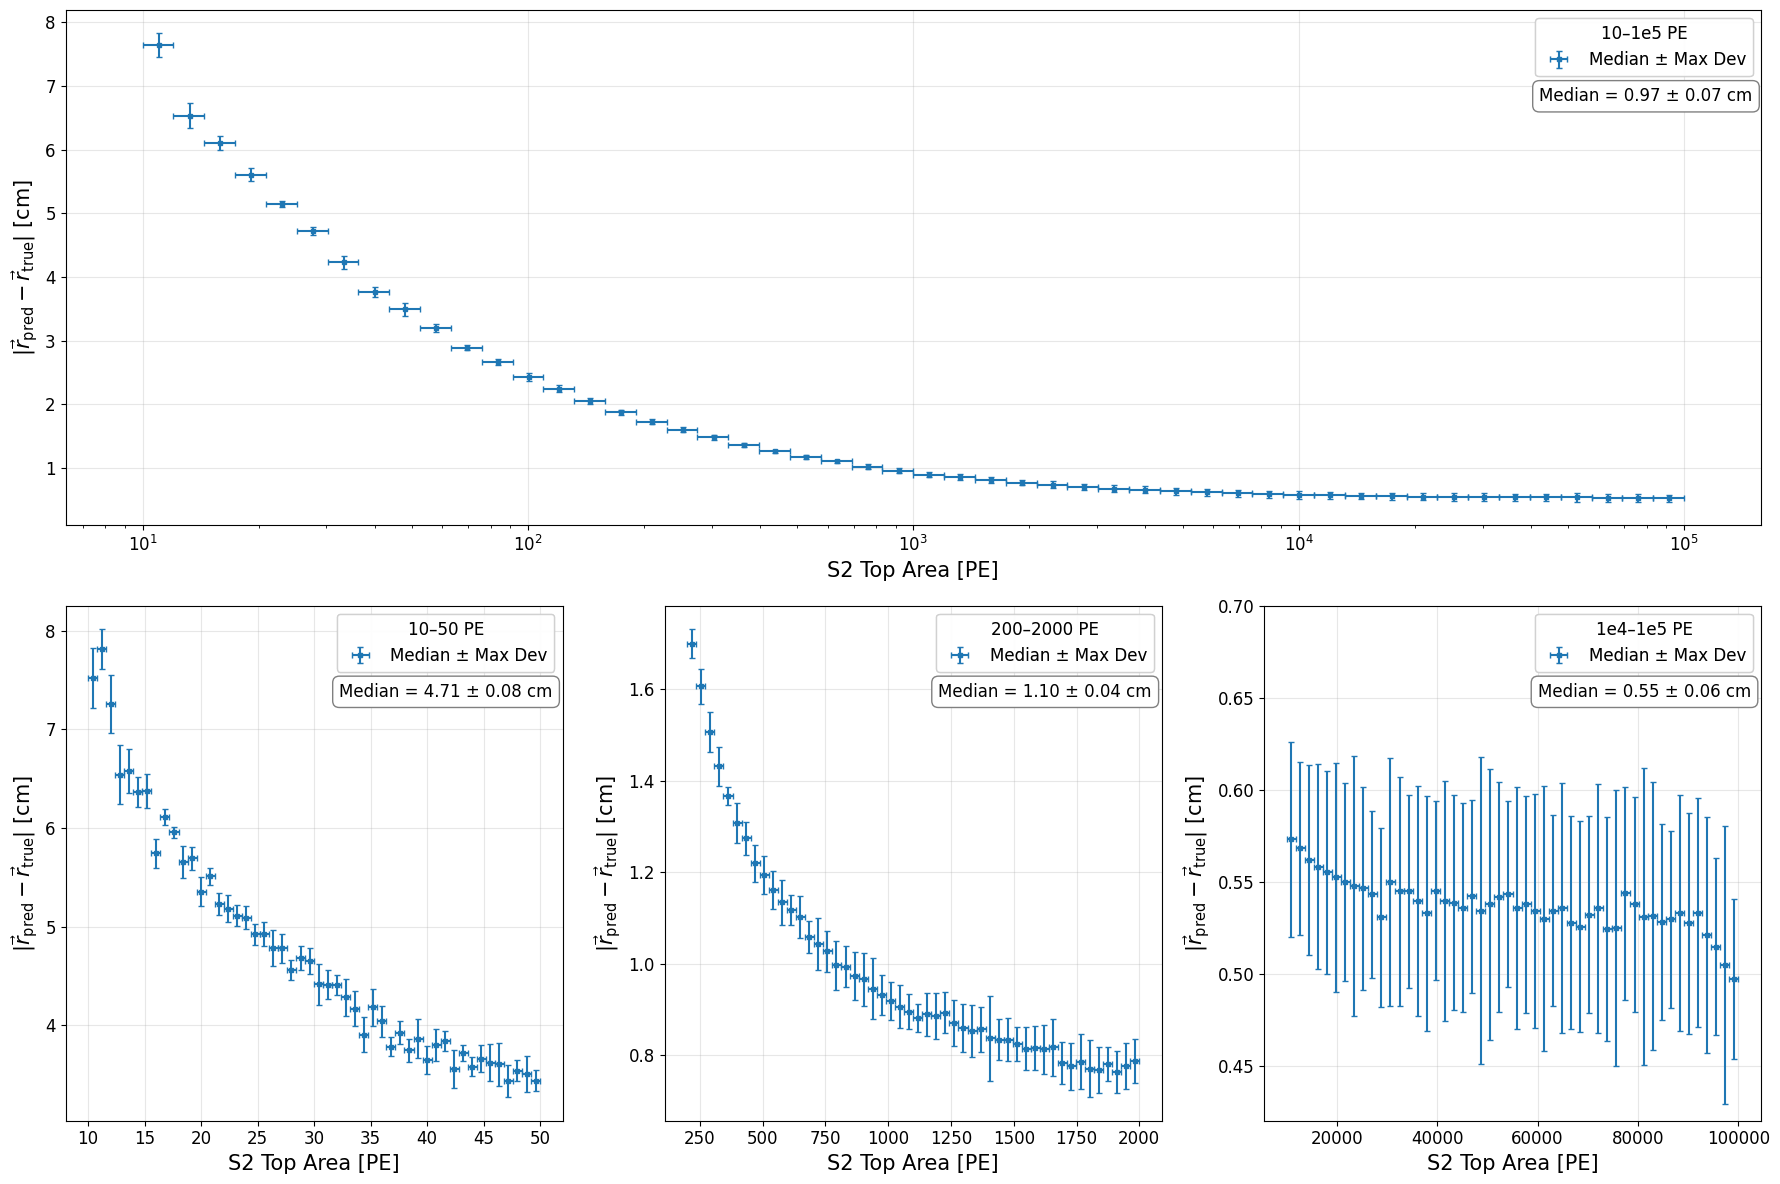

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import os
from matplotlib.gridspec import GridSpec

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
model_names = [f"ungrouped_{i}" for i in range(1, 11)]
n_bins = 50

main_range = (10, 1e5, '10–1e5 PE')
split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

def compute_binned_stats(area_min, area_max, use_log=True):
    bins = np.logspace(np.log10(area_min), np.log10(area_max), n_bins + 1) if use_log else np.linspace(area_min, area_max, n_bins + 1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])
    all_medians = []

    for model_name in model_names:
        path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            area = data["area_test"]
            abs_errors = data["abs_errors"]
        mask = (area >= area_min) & (area <= area_max)
        if not np.any(mask): continue
        median_per_bin, _, _ = binned_statistic(area[mask], abs_errors[mask], statistic='median', bins=bins)
        all_medians.append(median_per_bin)

    if not all_medians:
        return None
    all_medians = np.array(all_medians)
    mean_median = np.nanmean(all_medians, axis=0)
    max_dev_median = np.nanmax(np.abs(all_medians - mean_median[None, :]), axis=0)
    return bin_centers, bin_widths, mean_median, max_dev_median

def compute_global_median(area_min, area_max):
    medians = []
    for model_name in model_names:
        path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            area = data["area_test"]
            abs_errors = data["abs_errors"]
        mask = (area >= area_min) & (area <= area_max)
        if not np.any(mask): continue
        medians.append(np.median(abs_errors[mask]))
    if not medians:
        return None, None
    medians = np.array(medians)
    return np.mean(medians), np.max(np.abs(medians - np.mean(medians)))

# --- Plot setup ---
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 3, height_ratios=[1, 1], figure=fig)

# --- First row (log x-axis) ---
main_result = compute_binned_stats(*main_range[:2], use_log=True)
main_val, main_unc = compute_global_median(*main_range[:2])
if main_result:
    ax_main = fig.add_subplot(gs[0, :])
    bin_centers, bin_widths, mean_median, max_dev_median = main_result
    ax_main.errorbar(
        bin_centers, mean_median, xerr=bin_widths, yerr=max_dev_median,
        fmt='s', ms=3, capsize=2, label="Median ± Max Dev"
    )
    ax_main.set_xscale("log")
    ax_main.set_xlabel("S2 Top Area [PE]")
    ax_main.set_ylabel("$|\\vec{r}_\\mathrm{pred} - \\vec{r}_\\mathrm{true}|$ [cm]")
    ax_main.grid(alpha=0.3)

    # First legend
    legend1 = ax_main.legend(title=main_range[2], loc='upper right')
    ax_main.add_artist(legend1)

    # Second box (text)
    stats_text = f"Median = {main_val:.2f} ± {main_unc:.2f} cm"
    ax_main.text(
        0.995, 0.85, stats_text,
        transform=ax_main.transAxes,
        ha='right', va='top',
        fontsize='medium',
        bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.4')
    )

    print(f"{main_range[2]}: {main_val:.2f} ± {main_unc:.2f} cm")

# --- Second row (linear x-axes) ---
for i, (area_min, area_max, label) in enumerate(split_ranges):
    result = compute_binned_stats(area_min, area_max, use_log=False)
    val, unc = compute_global_median(area_min, area_max)
    if not result:
        continue

    ax = fig.add_subplot(gs[1, i])
    bin_centers, bin_widths, mean_median, max_dev_median = result
    ax.errorbar(
        bin_centers, mean_median, xerr=bin_widths, yerr=max_dev_median,
        fmt='s', ms=3, capsize=2, label="Median ± Max Dev"
    )
    ax.set_xlabel("S2 Top Area [PE]")
    ax.set_ylabel("$|\\vec{r}_\\mathrm{pred} - \\vec{r}_\\mathrm{true}|$ [cm]")
    ax.grid(alpha=0.3)

    # --- Only for 4th plot ---
    if i == 2:
        ax.set_ylim(0.42, 0.7)

    # First legend
    legend1 = ax.legend(title=label, loc='upper right')
    ax.add_artist(legend1)

    # Second box (text below legend)
    stats_text = f"Median = {val:.2f} ± {unc:.2f} cm"
    ax.text(
        0.98, 0.85, stats_text,
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize='medium',
        bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.4')
    )

    print(f"{label}: {val:.2f} ± {unc:.2f} cm")

plt.tight_layout()
#plt.show()
#plt.savefig("ungrouped_rec_err_vs_area_multi.png", dpi=300)

/scratch/local/jobs/33196217/ipykernel_4165359/1715632479.py:137: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend1 = ax.legend(title=label, loc='upper right')
/scratch/local/jobs/33196217/ipykernel_4165359/1715632479.py:137: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend1 = ax.legend(title=label, loc='upper right')


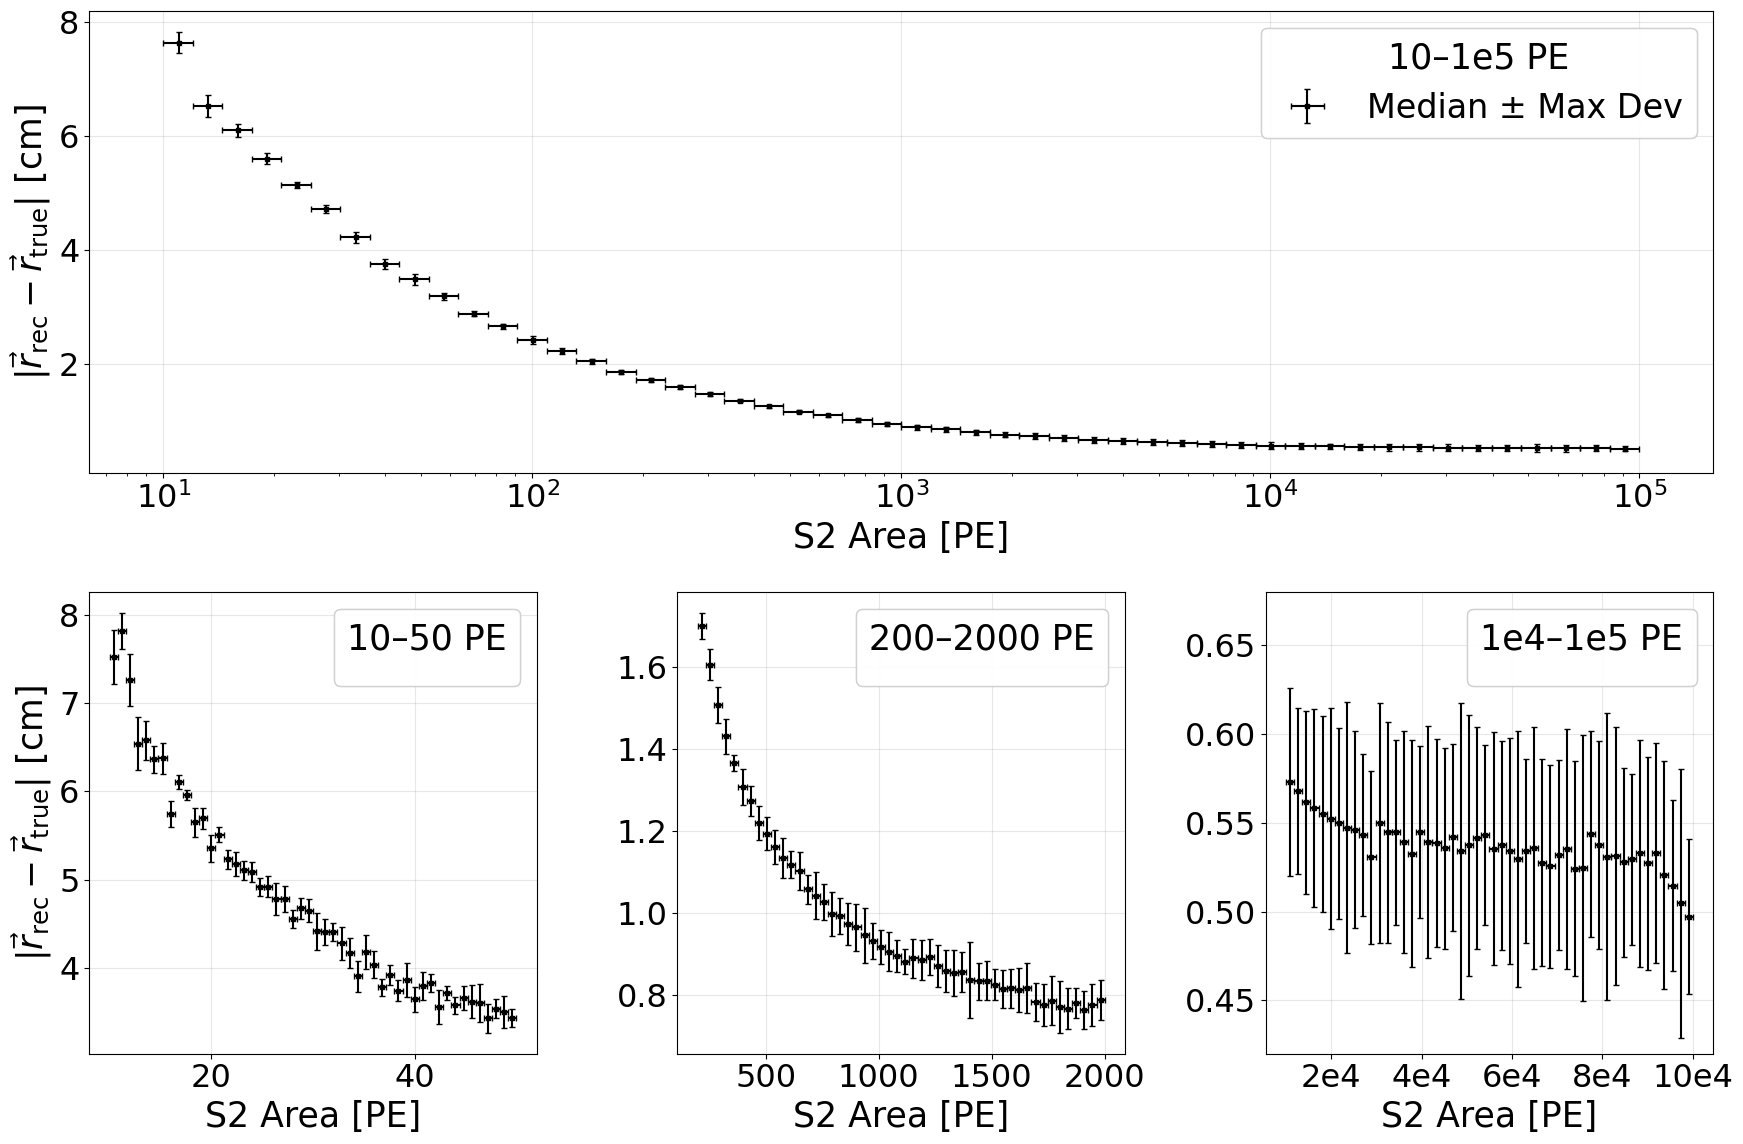

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import os
from matplotlib.gridspec import GridSpec

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 25,
    "axes.labelsize": 25,
    "axes.titlesize": 25,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 24
})

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
model_names = [f"ungrouped_{i}" for i in range(1, 11)]
n_bins = 50

main_range = (10, 1e5, '10–1e5 PE')
split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

def compute_binned_stats(area_min, area_max, use_log=True):
    bins = np.logspace(np.log10(area_min), np.log10(area_max), n_bins + 1) if use_log else np.linspace(area_min, area_max, n_bins + 1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])
    all_medians = []

    for model_name in model_names:
        path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            area = data["area_test"]
            abs_errors = data["abs_errors"]
        mask = (area >= area_min) & (area <= area_max)
        if not np.any(mask): continue
        median_per_bin, _, _ = binned_statistic(area[mask], abs_errors[mask], statistic='median', bins=bins)
        all_medians.append(median_per_bin)

    if not all_medians:
        return None
    all_medians = np.array(all_medians)
    mean_median = np.nanmean(all_medians, axis=0)
    max_dev_median = np.nanmax(np.abs(all_medians - mean_median[None, :]), axis=0)
    return bin_centers, bin_widths, mean_median, max_dev_median

def compute_global_percentiles(area_min, area_max):
    percentiles = {p: [] for p in [50, 68, 95, 99]}
    for model_name in model_names:
        path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            area = data["area_test"]
            abs_errors = data["abs_errors"]
        mask = (area >= area_min) & (area <= area_max)
        if not np.any(mask): continue
        for p in percentiles:
            percentiles[p].append(np.percentile(abs_errors[mask], p))

    stats = {}
    for p, values in percentiles.items():
        values = np.array(values)
        stats[p] = (np.mean(values), np.max(np.abs(values - np.mean(values))))
    return stats

# --- Plot setup ---
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 3, height_ratios=[1, 1], figure=fig)

# --- First row (log x-axis) ---
main_result = compute_binned_stats(*main_range[:2], use_log=True)
main_stats = compute_global_percentiles(*main_range[:2])
if main_result and main_stats:
    ax_main = fig.add_subplot(gs[0, :])
    bin_centers, bin_widths, mean_median, max_dev_median = main_result
    ax_main.errorbar(
        bin_centers, mean_median, xerr=bin_widths, yerr=max_dev_median,
        fmt='s', ms=3, capsize=2, color='black', ecolor='black', label="Median ± Max Dev"
    )
    ax_main.set_xscale("log")
    ax_main.set_xlabel("S2 Area [PE]")
    ax_main.set_ylabel("$|\\vec{r}_\\mathrm{rec} - \\vec{r}_\\mathrm{true}|$ [cm]")
    ax_main.grid(alpha=0.3)

    legend1 = ax_main.legend(title=main_range[2], loc='upper right')
    ax_main.add_artist(legend1)

    stats_text = "\n".join([
        f"Median = {main_stats[50][0]:.2f} ± {main_stats[50][1]:.2f} cm",
    ])
    #ax_main.text(
     #   0.995, 0.85, stats_text,
      #  transform=ax_main.transAxes,
       # ha='right', va='top',
        #fontsize='medium',
        #bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4')
    #)

# --- Second row (linear x-axes) ---
for i, (area_min, area_max, label) in enumerate(split_ranges):
    result = compute_binned_stats(area_min, area_max, use_log=False)
    stats = compute_global_percentiles(area_min, area_max)
    if not result or not stats:
        continue

    ax = fig.add_subplot(gs[1, i])
    bin_centers, bin_widths, mean_median, max_dev_median = result
    ax.errorbar(
        bin_centers, mean_median, xerr=bin_widths, yerr=max_dev_median,
        fmt='s', ms=3, capsize=2, color='black', ecolor='black'#, label="Median ± Max Dev"
    )
    ax.set_xlabel("S2 Area [PE]")

    # Only left subplot in 2nd row gets the ylabel
    if i == 0:
        ax.set_ylabel("$|\\vec{r}_\\mathrm{rec} - \\vec{r}_\\mathrm{true}|$ [cm]")

    ax.grid(alpha=0.3)

    # Fix bottom right plot (overlapping ticks)
    if i == 2:
        ax.set_ylim(0.42, 0.68)

        # Define custom ticks for better readability
        custom_ticks = [2e4, 4e4, 6e4, 8e4, 1e5]
        ax.set_xticks(custom_ticks)
        ax.set_xticklabels([f"{int(tick/1e4)}e4" for tick in custom_ticks])

    legend1 = ax.legend(title=label, loc='upper right')
    ax.add_artist(legend1)

    stats_text = "\n".join([
        f"Median = {stats[50][0]:.2f} ± {stats[50][1]:.2f} cm",
    ])
    #ax.text(
     #   0.97, 0.75, stats_text,
      #  transform=ax.transAxes,
       # ha='right', va='top',
        #fontsize='medium',
        #bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4')
    #)

plt.tight_layout()
#plt.savefig("ungrouped_rec_err_vs_area_multi_bw.png", dpi=300)
plt.show()


10–1e5 PE: 0.04 ± 0.17 cm
10–50 PE: -0.19 ± 0.19 cm
200–2000 PE: 0.06 ± 0.16 cm
1e4–1e5 PE: 0.04 ± 0.18 cm


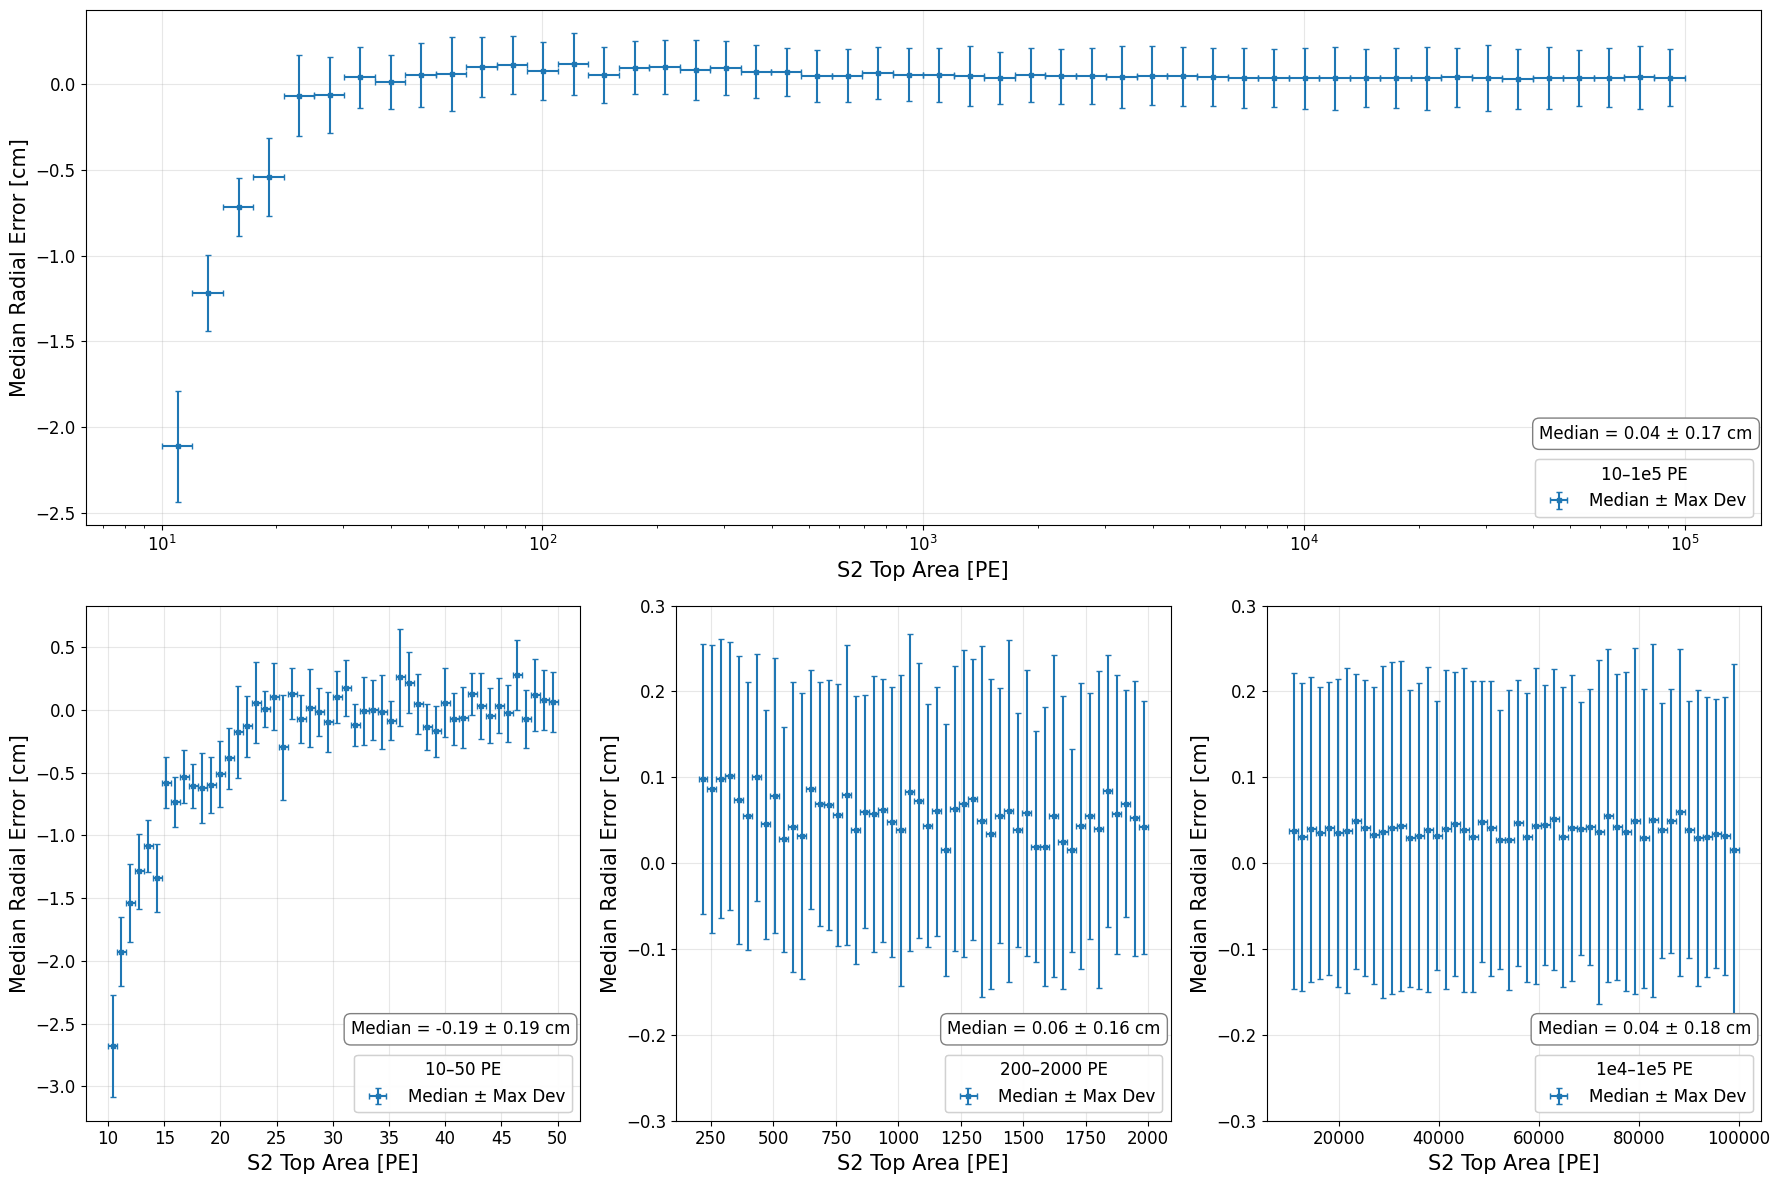

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import os
from matplotlib.gridspec import GridSpec

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
model_names = [f"ungrouped_{i}" for i in range(1, 11)]
n_bins = 50

main_range = (10, 1e5, '10–1e5 PE')
split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

# --- Functions ---
def compute_binned_stats(area_min, area_max, use_log=True):
    bins = np.logspace(np.log10(area_min), np.log10(area_max), n_bins + 1) if use_log else np.linspace(area_min, area_max, n_bins + 1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])
    all_medians = []

    for model_name in model_names:
        path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            area = data["area_test"]
            radial_errors = data["radial_errors"]
        mask = (area >= area_min) & (area <= area_max)
        if not np.any(mask):
            continue
        median_per_bin, _, _ = binned_statistic(area[mask], radial_errors[mask], statistic='median', bins=bins)
        all_medians.append(median_per_bin)

    if not all_medians:
        return None

    all_medians = np.array(all_medians)
    mean_median = np.nanmean(all_medians, axis=0)
    max_dev_median = np.nanmax(np.abs(all_medians - mean_median[None, :]), axis=0)
    return bin_centers, bin_widths, mean_median, max_dev_median

def compute_global_median(area_min, area_max):
    medians = []
    for model_name in model_names:
        path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            area = data["area_test"]
            radial_errors = data["radial_errors"]
        mask = (area >= area_min) & (area <= area_max)
        if not np.any(mask):
            continue
        global_median = np.median(radial_errors[mask])
        medians.append(global_median)

    if not medians:
        return None, None

    medians = np.array(medians)
    mean_of_medians = np.mean(medians)
    max_deviation = np.max(np.abs(medians - mean_of_medians))
    return mean_of_medians, max_deviation

# --- Plot setup ---
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 3, height_ratios=[1, 1], figure=fig)

# --- Row 1: full-width, log x-axis ---
main_plot = compute_binned_stats(*main_range[:2], use_log=True)
main_val, main_unc = compute_global_median(*main_range[:2])
if main_plot:
    bin_centers, bin_widths, mean_median, max_dev_median = main_plot
    ax_main = fig.add_subplot(gs[0, :])
    ax_main.errorbar(bin_centers, mean_median, xerr=bin_widths, yerr=max_dev_median,
                     fmt='s', ms=3, capsize=2, label="Median ± Max Dev")
    ax_main.set_xscale("log")
    ax_main.set_xlabel("S2 Top Area [PE]")
    ax_main.set_ylabel("Median Radial Error [cm]")
    ax_main.grid(alpha=0.3)

    # First legend
    legend1 = ax_main.legend(title=main_range[2], loc='lower right')
    ax_main.add_artist(legend1)

    # Second box (text)
    stats_text = f"Median = {main_val:.2f} ± {main_unc:.2f} cm"
    ax_main.text(
        0.995, 0.16, stats_text,
        transform=ax_main.transAxes,
        ha='right', va='bottom',
        fontsize='medium',
        bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.4')
    )

    print(f"{main_range[2]}: {main_val:.2f} ± {main_unc:.2f} cm")

# --- Row 2: three linear x-axis plots ---
for i, (area_min, area_max, label) in enumerate(split_ranges):
    result = compute_binned_stats(area_min, area_max, use_log=False)
    val, unc = compute_global_median(area_min, area_max)
    if not result:
        continue
    bin_centers, bin_widths, mean_median, max_dev_median = result
    ax = fig.add_subplot(gs[1, i])
    ax.errorbar(bin_centers, mean_median, xerr=bin_widths, yerr=max_dev_median,
                fmt='s', ms=3, capsize=2, label="Median ± Max Dev")
    ax.set_xlabel("S2 Top Area [PE]")
    ax.set_ylabel("Median Radial Error [cm]")
    ax.grid(alpha=0.3)

    # --- Only for 4th plot ---
    if i == 1:
        ax.set_ylim(-0.3, 0.3)
    if i == 2:
        ax.set_ylim(-0.3, 0.3)

    # First legend
    legend1 = ax.legend(title=label, loc='lower right')
    ax.add_artist(legend1)

    # Second box (text below legend)
    stats_text = f"Median = {val:.2f} ± {unc:.2f} cm"
    ax.text(
        0.98, 0.16, stats_text,
        transform=ax.transAxes,
        ha='right', va='bottom',
        fontsize='medium',
        bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.4')
    )

    print(f"{label}: {val:.2f} ± {unc:.2f} cm")

plt.tight_layout()
#plt.show()
#plt.savefig("ungrouped_rad_err_vs_area_multi.png", dpi=300)


/scratch/local/jobs/33196217/ipykernel_4165359/3013438243.py:152: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=label, loc='lower right')
/scratch/local/jobs/33196217/ipykernel_4165359/3013438243.py:152: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=label, loc='lower right')


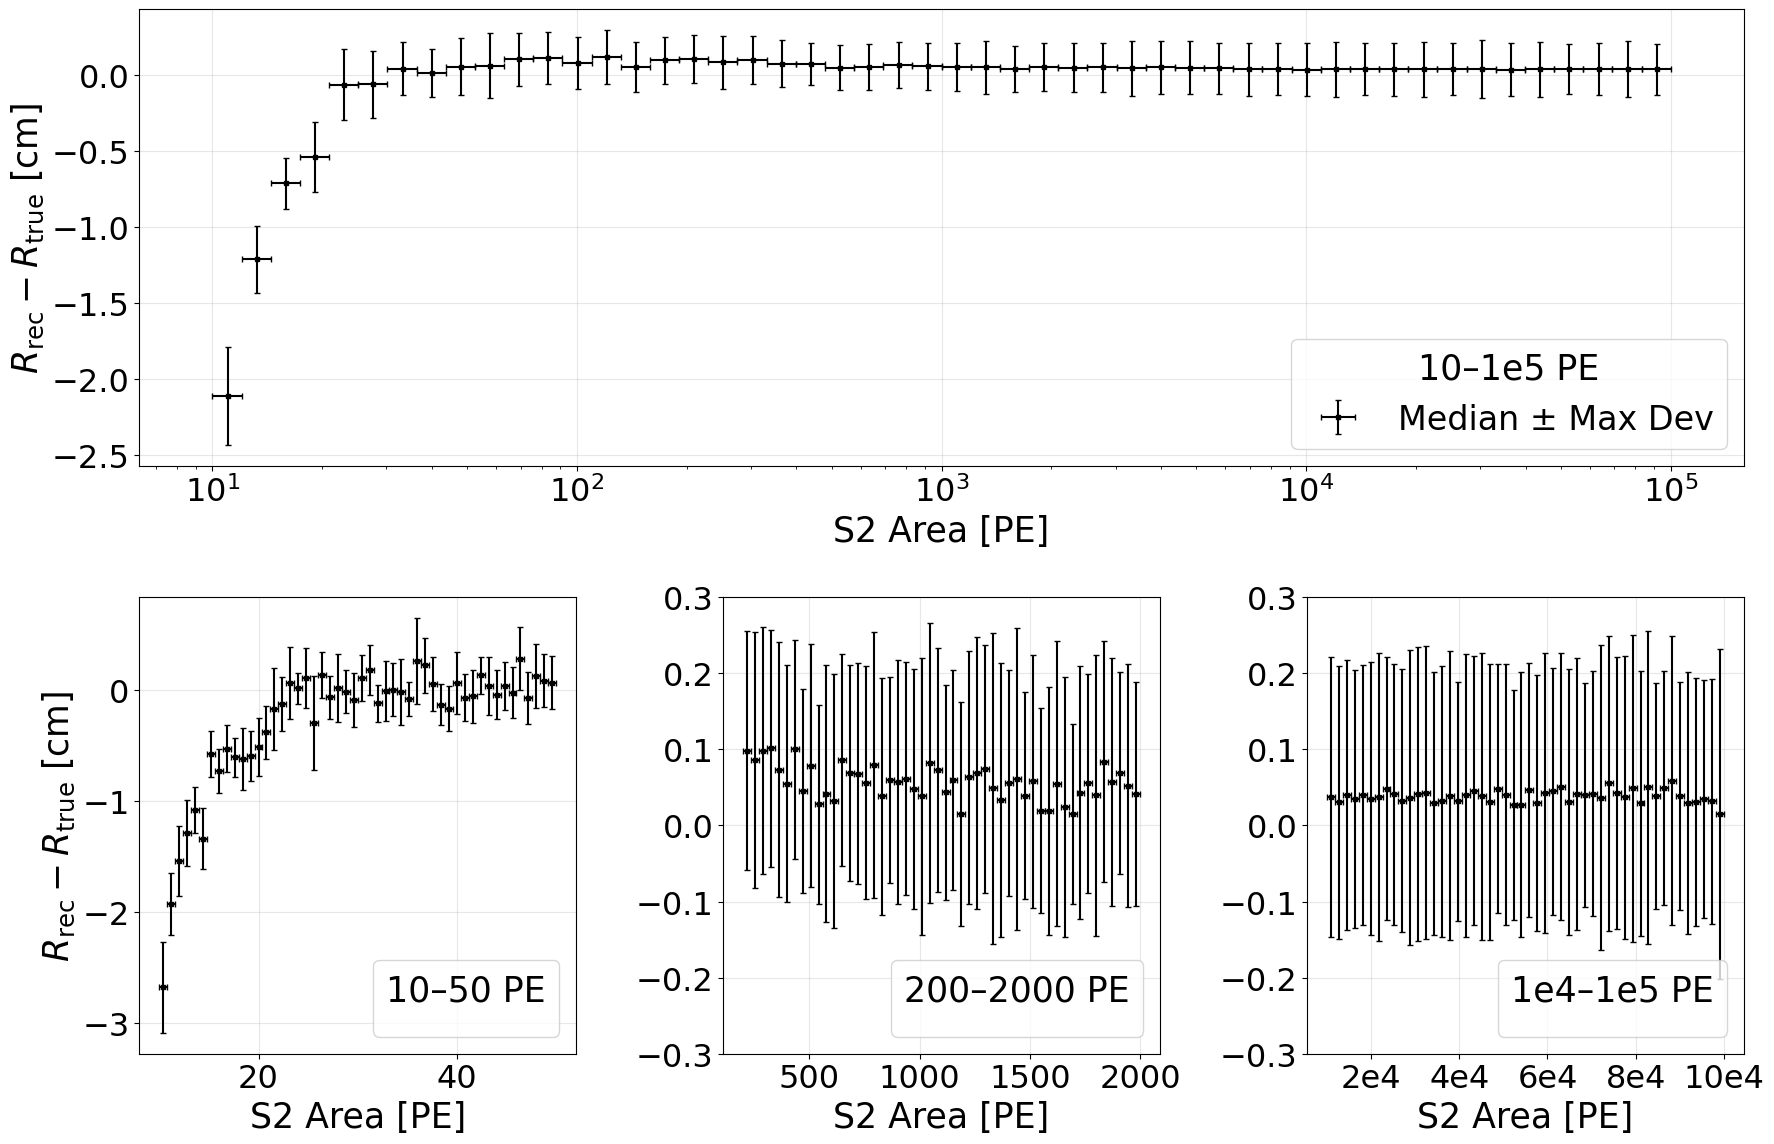

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import os
from matplotlib.gridspec import GridSpec

# --- Font size setup to match reference layout ---
plt.rcParams.update({
    "font.size": 25,
    "axes.labelsize": 25,
    "axes.titlesize": 25,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 24
})

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
model_names = [f"ungrouped_{i}" for i in range(1, 11)]
n_bins = 50

main_range = (10, 1e5, '10–1e5 PE')
split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

# --- Functions ---
def compute_binned_stats(area_min, area_max, use_log=True):
    bins = np.logspace(np.log10(area_min), np.log10(area_max), n_bins + 1) if use_log else np.linspace(area_min, area_max, n_bins + 1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])
    all_medians = []

    for model_name in model_names:
        path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            area = data["area_test"]
            radial_errors = data["radial_errors"]
        mask = (area >= area_min) & (area <= area_max)
        if not np.any(mask):
            continue
        median_per_bin, _, _ = binned_statistic(area[mask], radial_errors[mask], statistic='median', bins=bins)
        all_medians.append(median_per_bin)

    if not all_medians:
        return None

    all_medians = np.array(all_medians)
    mean_median = np.nanmean(all_medians, axis=0)
    max_dev_median = np.nanmax(np.abs(all_medians - mean_median[None, :]), axis=0)
    return bin_centers, bin_widths, mean_median, max_dev_median

def compute_global_percentiles(area_min, area_max):
    percentiles = {p: [] for p in [50, 68, 95, 99]}
    for model_name in model_names:
        path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            area = data["area_test"]
            radial_errors = data["radial_errors"]
        mask = (area >= area_min) & (area <= area_max)
        if not np.any(mask):
            continue
        for p in percentiles:
            percentiles[p].append(np.percentile(radial_errors[mask], p))

    stats = {}
    for p, values in percentiles.items():
        values = np.array(values)
        stats[p] = (np.mean(values), np.max(np.abs(values - np.mean(values))))
    return stats

def compute_global_abs_percentiles(area_min, area_max):
    percentiles = {p: [] for p in [50, 68, 95, 99]}
    for model_name in model_names:
        path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            area = data["area_test"]
            radial_errors = np.abs(data["radial_errors"])
        mask = (area >= area_min) & (area <= area_max)
        if not np.any(mask):
            continue
        for p in percentiles:
            percentiles[p].append(np.percentile(radial_errors[mask], p))

    stats = {}
    for p, values in percentiles.items():
        values = np.array(values)
        stats[p] = (np.mean(values), np.max(np.abs(values - np.mean(values))))
    return stats

# --- Plot setup ---
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 3, height_ratios=[1, 1], figure=fig)

# --- Row 1: full-width, log x-axis ---
main_plot = compute_binned_stats(*main_range[:2], use_log=True)
main_stats_signed = compute_global_percentiles(*main_range[:2])
main_stats_abs = compute_global_abs_percentiles(*main_range[:2])

if main_plot and main_stats_signed and main_stats_abs:
    bin_centers, bin_widths, mean_median, max_dev_median = main_plot
    ax_main = fig.add_subplot(gs[0, :])
    ax_main.errorbar(bin_centers, mean_median, xerr=bin_widths, yerr=max_dev_median,
                     fmt='s', ms=3, capsize=2, color='black', ecolor='black', label="Median ± Max Dev")
    ax_main.set_xscale("log")
    ax_main.set_xlabel("S2 Area [PE]")
    ax_main.set_ylabel("$R_\\mathrm{rec} - R_\\mathrm{true}$ [cm]")
    ax_main.grid(alpha=0.3)

    # Legend
    ax_main.legend(title=main_range[2], loc='lower right')

# --- Row 2: three linear x-axis plots ---
for i, (area_min, area_max, label) in enumerate(split_ranges):
    result = compute_binned_stats(area_min, area_max, use_log=False)
    stats_signed = compute_global_percentiles(area_min, area_max)
    stats_abs = compute_global_abs_percentiles(area_min, area_max)

    if not result or not stats_signed or not stats_abs:
        continue
    bin_centers, bin_widths, mean_median, max_dev_median = result
    ax = fig.add_subplot(gs[1, i])
    ax.errorbar(bin_centers, mean_median, xerr=bin_widths, yerr=max_dev_median,
                fmt='s', ms=3, capsize=2, color='black', ecolor='black')
    ax.set_xlabel("S2 Area [PE]")

    # Only left plot gets y-label
    if i == 0:
        ax.set_ylabel("$R_\\mathrm{rec} - R_\\mathrm{true}$ [cm]")

    ax.grid(alpha=0.3)

    if i == 1:
        ax.set_ylim(-0.3, 0.3)

    # Fix tick clutter on far right plot
    if i == 2:
        ax.set_ylim(-0.3, 0.3)
        custom_ticks = [2e4, 4e4, 6e4, 8e4, 1e5]
        ax.set_xticks(custom_ticks)
        ax.set_xticklabels([f"{int(t/1e4)}e4" for t in custom_ticks])

    # Legend
    ax.legend(title=label, loc='lower right')

plt.tight_layout()
#plt.savefig("ungrouped_rad_err_vs_area_multi_bw.png", dpi=300)
plt.show()


# Detector Zones

10–50 PE: 42.62% of events with r_true ≥ 60 cm have r_pred < 60 cm
200–2000 PE: 8.99% of events with r_true ≥ 61.35 cm have r_pred < 61.35 cm
1e4–1e5 PE: 1.62% of events with r_true ≥ 61.35 cm have r_pred < 61.35 cm


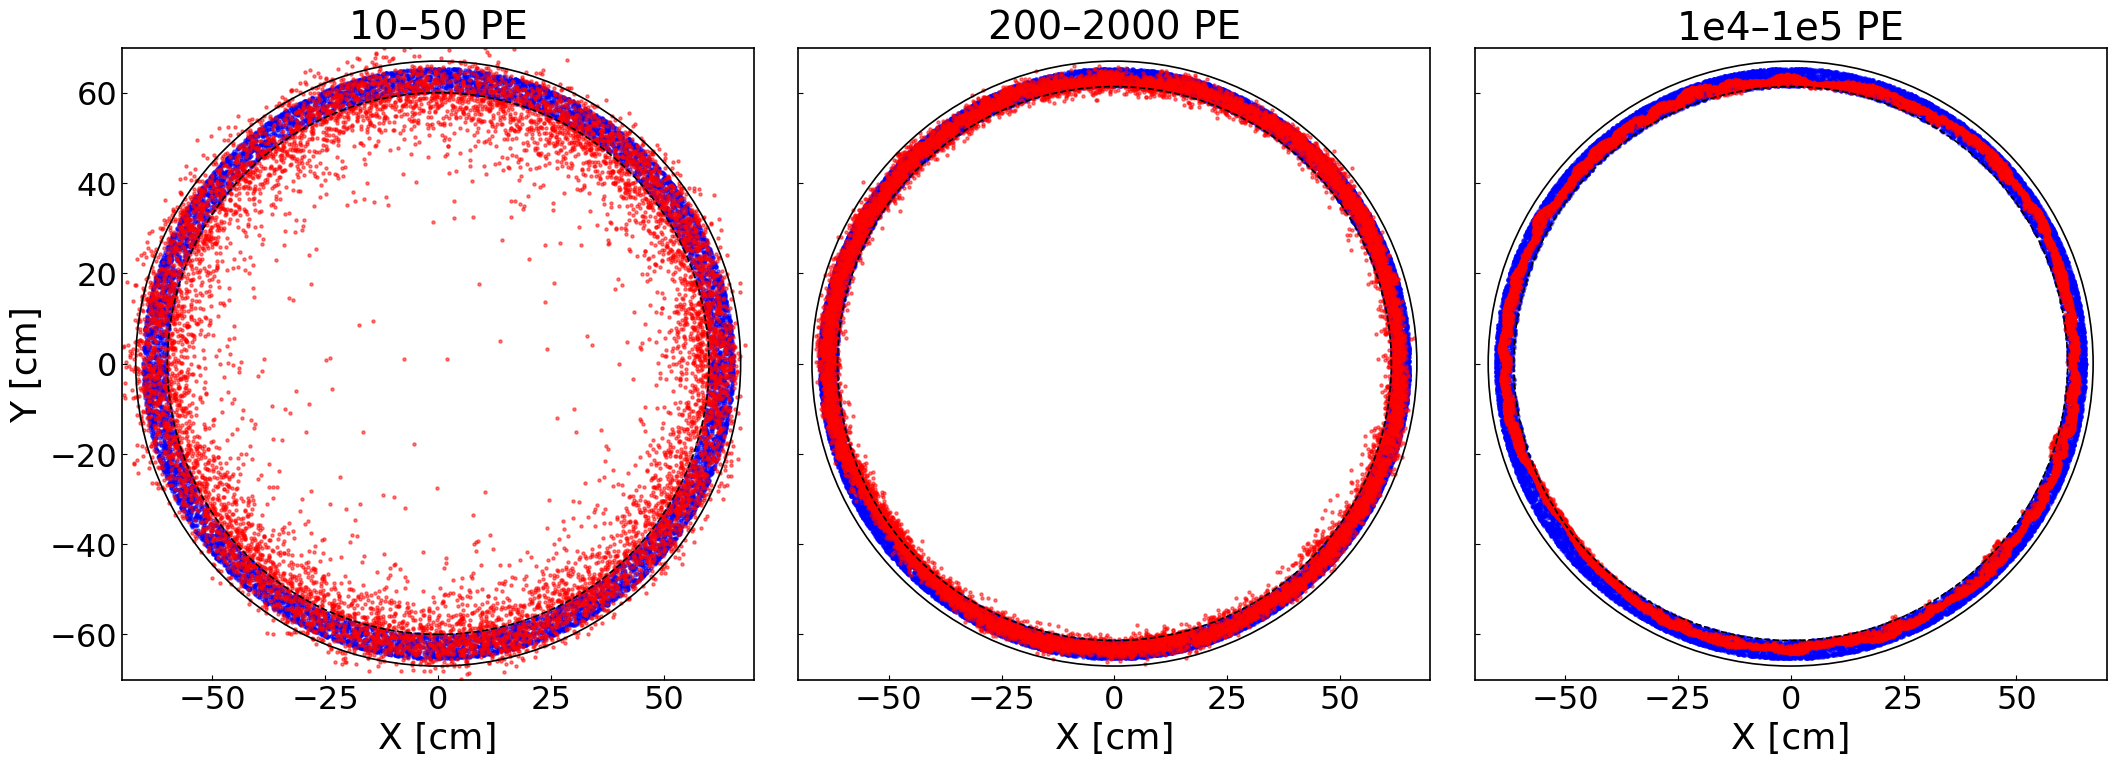

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 26,
    "axes.labelsize": 26,
    "axes.titlesize": 28,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 26
})

# --- Area and threshold definitions ---
area_keys = ['area_10_50', 'area_200_2000', 'area_1e4_1e5']
area_labels = ['10–50 PE', '200–2000 PE', '1e4–1e5 PE']
r_true_thresholds = [60, 61.35, 61.35]

# --- Plot setup ---
fig, axes = plt.subplots(1, 3, figsize=(21, 8.5), sharex=True, sharey=True)
fig.subplots_adjust(left=0.04, right=0.985, bottom=0.11, top=0.86, wspace=0.07)

# --- Plot each energy range ---
for ax, key, label, r_thr in zip(axes, area_keys, area_labels, r_true_thresholds):
    result = all_results[key]
    pos_test = result["pos_test"]
    pos_pred = result["pos_pred"]

    r_true = np.linalg.norm(pos_test, axis=1)
    r_pred = np.linalg.norm(pos_pred, axis=1)
    mask_outer = r_true >= r_thr
    mask_leak = r_pred[mask_outer] < r_thr

    # Plot true and predicted positions for outer events
    ax.scatter(pos_test[mask_outer, 0], pos_test[mask_outer, 1],
               s=5, alpha=0.5, color='blue', label='True Position')
    ax.scatter(pos_pred[mask_outer, 0], pos_pred[mask_outer, 1],
               s=5, alpha=0.5, color='red', label='Reconstructed Position')

    # Draw fiducial and detector boundary circles
    ax.add_patch(plt.Circle((0, 0), r_thr, color='black', linestyle='--', fill=False, linewidth=1.2))
    ax.add_patch(plt.Circle((0, 0), 67, color='black', linestyle='-', fill=False, linewidth=1.2))

    ax.set_title(label)
    ax.set_xlabel("X [cm]")
    if ax is axes[0]:
        ax.set_ylabel("Y [cm]")
    ax.set_xlim(-70, 70)
    ax.set_ylim(-70, 70)
    ax.set_aspect('equal')
    #ax.grid(alpha=0.3)

    # Optional legend
    # ax.legend(loc='upper left')

# --- Print leakage percentages ---
for key, label, r_thr in zip(area_keys, area_labels, r_true_thresholds):
    result = all_results[key]
    pos_test = result["pos_test"]
    pos_pred = result["pos_pred"]

    r_true = np.linalg.norm(pos_test, axis=1)
    r_pred = np.linalg.norm(pos_pred, axis=1)

    mask_outer = r_true >= r_thr
    mask_leak = r_pred[mask_outer] < r_thr

    if np.sum(mask_outer) > 0:
        percentage = 100 * np.sum(mask_leak) / np.sum(mask_outer)
        print(f"{label}: {percentage:.2f}% of events with r_true ≥ {r_thr} cm have r_pred < {r_thr} cm")
    else:
        print(f"{label}: No events with r_true ≥ {r_thr} cm")

# --- Optional save or show ---
#plt.savefig("ungrouped_true_vs_reconstructed_positions_outside_FV.png", dpi=300)
# plt.show()


In [39]:
# --- Compute containment percentages for all 10 runs ---
model_keys = list(combined_results.keys())  # e.g. ['ungrouped_1', ..., 'ungrouped_10']

for area_key, area_label in zip(area_keys, area_labels):
    percentages = []

    for model_key in model_keys:
        result = combined_results[model_key].get(area_key)
        if result is None:
            continue  # Skip if this model has no data for the area

        pos_test = result["pos_test"]
        pos_pred = result["pos_pred"]

        r_true = np.linalg.norm(pos_test, axis=1)
        r_pred = np.linalg.norm(pos_pred, axis=1)

        mask_outer = r_true >= 60
        mask_leak = r_pred[mask_outer] < 60

        if np.sum(mask_outer) > 0:
            percent = 100 * np.sum(mask_leak) / np.sum(mask_outer)
            percentages.append(percent)

    if percentages:
        avg = np.mean(percentages)
        max_dev = np.max(np.abs(np.array(percentages) - avg))
        print(f"{area_label}: {avg:.2f}% ± {max_dev:.2f}% of events with r_true ≥ 60 cm have r_pred < 60 cm")
    else:
        print(f"{area_label}: No valid data across training runs.")


10–50 PE: 44.24% ± 1.95% of events with r_true ≥ 60 cm have r_pred < 60 cm
200–2000 PE: 4.16% ± 0.81% of events with r_true ≥ 60 cm have r_pred < 60 cm
1e4–1e5 PE: 0.74% ± 0.61% of events with r_true ≥ 60 cm have r_pred < 60 cm


In [43]:
# --- Compute containment percentages for all 10 runs ---
model_keys = list(combined_results.keys())  # e.g. ['ungrouped_1', ..., 'ungrouped_10']

# Use thresholds matching the plot logic
r_true_thresholds = [60, 61.35, 61.35]

for area_key, area_label, r_thr in zip(area_keys, area_labels, r_true_thresholds):
    percentages = []

    for model_key in model_keys:
        result = combined_results[model_key].get(area_key)
        if result is None:
            continue  # Skip if this model has no data for the area

        pos_test = result["pos_test"]
        pos_pred = result["pos_pred"]

        r_true = np.linalg.norm(pos_test, axis=1)
        r_pred = np.linalg.norm(pos_pred, axis=1)

        mask_outer = r_true >= r_thr
        mask_leak = r_pred[mask_outer] < r_thr

        if np.sum(mask_outer) > 0:
            percent = 100 * np.sum(mask_leak) / np.sum(mask_outer)
            percentages.append(percent)

    if percentages:
        avg = np.mean(percentages)
        max_dev = np.max(np.abs(np.array(percentages) - avg))
        print(f"{area_label}: {avg:.2f}% ± {max_dev:.2f}% of events with r_true ≥ {r_thr} cm have r_pred < {r_thr} cm")
    else:
        print(f"{area_label}: No valid data across training runs.")


10–50 PE: 44.24% ± 1.95% of events with r_true ≥ 60 cm have r_pred < 60 cm
200–2000 PE: 10.10% ± 2.12% of events with r_true ≥ 61.35 cm have r_pred < 61.35 cm
1e4–1e5 PE: 1.74% ± 1.05% of events with r_true ≥ 61.35 cm have r_pred < 61.35 cm


/scratch/local/jobs/33464439/ipykernel_910254/1672785963.py:121: RuntimeWarning: Mean of empty slice
  avg_means = np.nanmean(run_means, axis=0)
/scratch/local/jobs/33464439/ipykernel_910254/1672785963.py:122: RuntimeWarning: All-NaN slice encountered
  std_means = np.nanmax(np.abs(run_means - avg_means), axis=0)  # max deviation across runs
/scratch/local/jobs/33464439/ipykernel_910254/1672785963.py:121: RuntimeWarning: Mean of empty slice
  avg_means = np.nanmean(run_means, axis=0)
/scratch/local/jobs/33464439/ipykernel_910254/1672785963.py:122: RuntimeWarning: All-NaN slice encountered
  std_means = np.nanmax(np.abs(run_means - avg_means), axis=0)  # max deviation across runs
/scratch/local/jobs/33464439/ipykernel_910254/1672785963.py:121: RuntimeWarning: Mean of empty slice
  avg_means = np.nanmean(run_means, axis=0)
/scratch/local/jobs/33464439/ipykernel_910254/1672785963.py:122: RuntimeWarning: All-NaN slice encountered
  std_means = np.nanmax(np.abs(run_means - avg_means), axis=

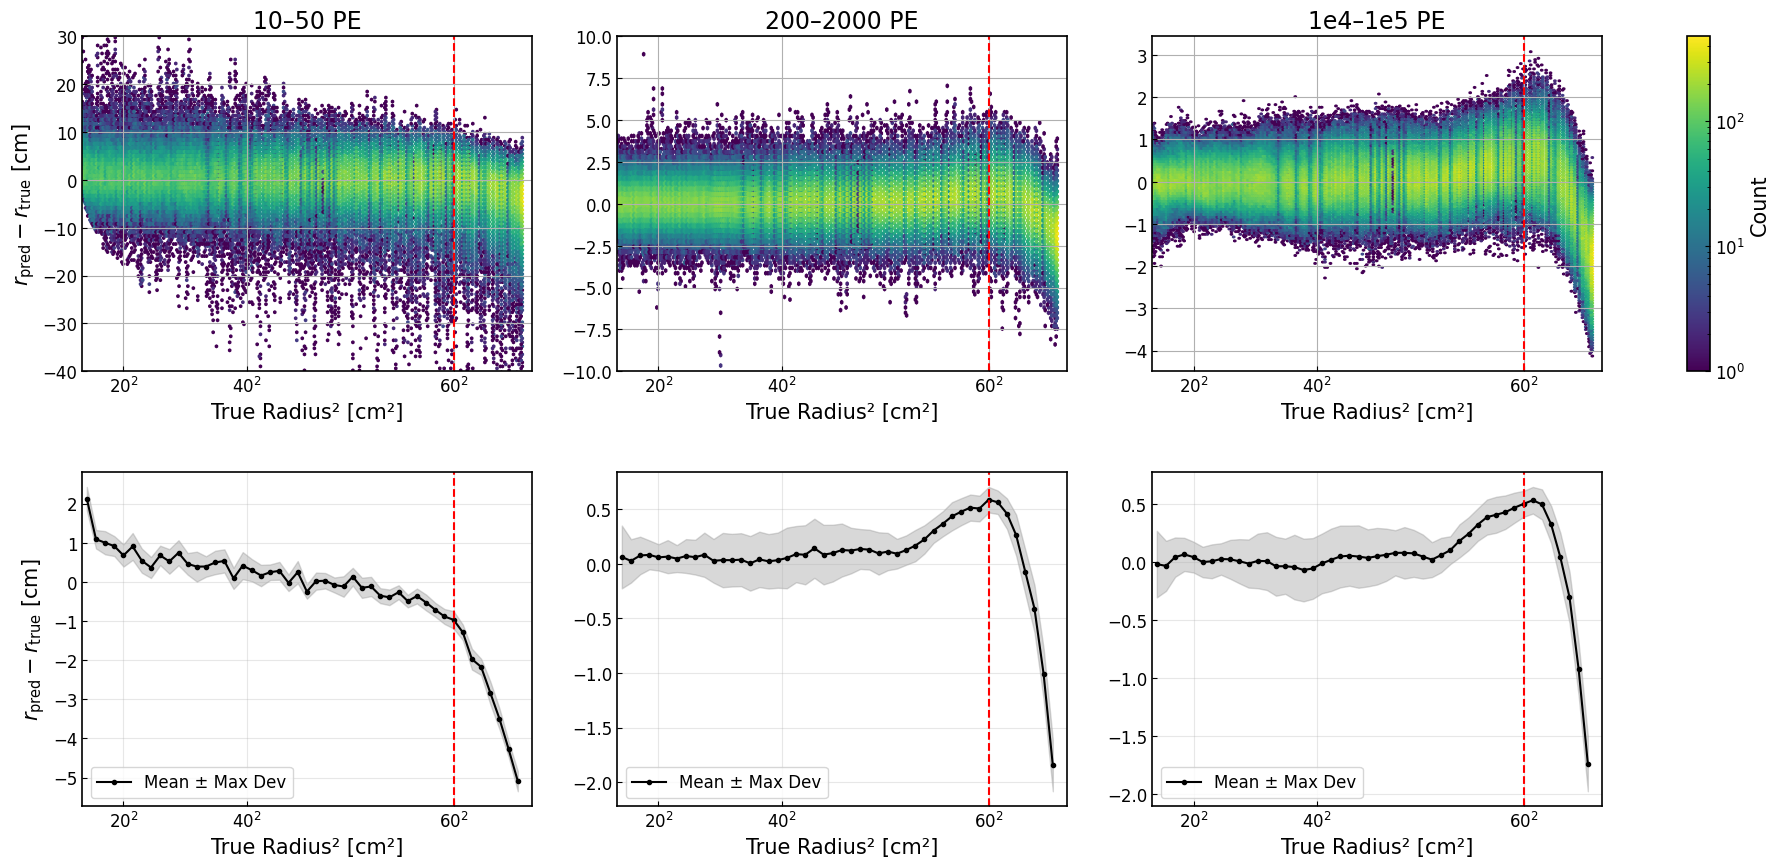

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import os

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Configuration ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
model_names = [f'ungrouped_{i}' for i in range(1, 11)]
area_keys = ['area_10_50', 'area_200_2000', 'area_1e4_1e5']
area_labels = ['10–50 PE', '200–2000 PE', '1e4–1e5 PE']
bin_edges = np.linspace(0, 66**2, 50)
tick_vals = [20**2, 40**2, 60**2]
tick_labels = [r"$20^2$", r"$40^2$", r"$60^2$"]

# --- Load all results ---
combined_results = {key: [] for key in area_keys}
for model_name in model_names:
    path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
    if not os.path.exists(path):
        continue
    with np.load(path) as data:
        area_test = data['area_test']
        pos_test = data['pos_test']
        pos_pred = data['pos_pred']
        radial_errors = data['radial_errors']

    area_ranges = {
        'area_10_50': (10, 50),
        'area_200_2000': (200, 2000),
        'area_1e4_1e5': (1e4, 1e5)
    }

    for key in area_keys:
        area_min, area_max = area_ranges[key]

        mask = (area_test >= area_min) & (area_test <= area_max)
        if not np.any(mask):
            continue
        combined_results[key].append({
            'pos_test': pos_test[mask],
            'pos_pred': pos_pred[mask],
            'radial_errors': radial_errors[mask]
        })

# --- Full figure ---
fig = plt.figure(figsize=(21, 10))
gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05], height_ratios=[1, 1], hspace=0.3, wspace=0.25)

# --- Row 1: Hexbin plots (combined data from all 10 runs) ---
for i, (key, label) in enumerate(zip(area_keys, area_labels)):
    ax = fig.add_subplot(gs[0, i])
    all_r_true2, all_r_diff = [], []

    for run in combined_results[key]:
        r_true = np.linalg.norm(run['pos_test'], axis=1)
        r_pred = np.linalg.norm(run['pos_pred'], axis=1)
        r_diff = r_pred - r_true
        all_r_true2.append(r_true**2)
        all_r_diff.append(r_diff)

    r_true2_concat = np.concatenate(all_r_true2)
    r_diff_concat = np.concatenate(all_r_diff)

    hb = ax.hexbin(r_true2_concat, r_diff_concat, gridsize=200, cmap='viridis', mincnt=1, norm=LogNorm())

    ax.set_title(label)
    ax.set_xlabel('True Radius² [cm²]')
    if i == 0:
        ax.set_ylabel("$r_\\mathrm{pred} - r_\\mathrm{true}$ [cm]")
    ax.grid(True)
    ax.axvline(x=60**2, color='red', linestyle='--', linewidth=1.5)
    ax.set_xlim(0, 66**2)

    if key == "area_10_50":
        ax.set_ylim(-40, 30)
    if key == "area_200_2000":
        ax.set_ylim(-10, 10)

    ax.set_xticks(tick_vals)
    ax.set_xticklabels(tick_labels)

# --- Shared colorbar ---
cax = fig.add_subplot(gs[0, 3])
cb = fig.colorbar(hb, cax=cax)
cb.set_label("Count")

# --- Row 2: Mean radial error vs distance² ---
for i, (key, label) in enumerate(zip(area_keys, area_labels)):
    ax = fig.add_subplot(gs[1, i])

    # Collect per-bin means from each run
    run_means = []
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    for run in combined_results[key]:
        radial_errors = run['radial_errors']
        pos_test = run['pos_test']
        r2 = np.sum(pos_test**2, axis=1)

        means = []
        for j in range(len(bin_edges) - 1):
            mask = (r2 >= bin_edges[j]) & (r2 < bin_edges[j + 1])
            if np.any(mask):
                means.append(np.mean(radial_errors[mask]))
            else:
                means.append(np.nan)
        run_means.append(means)

    run_means = np.array(run_means)
    avg_means = np.nanmean(run_means, axis=0)
    std_means = np.nanmax(np.abs(run_means - avg_means), axis=0)  # max deviation across runs

    ax.plot(bin_centers, avg_means, color='black', marker='o', ms=3, label='Mean ± Max Dev')
    ax.fill_between(bin_centers, avg_means - std_means, avg_means + std_means, color='gray', alpha=0.3)

    ax.set_xlabel("True Radius² [cm²]")
    if i == 0:
        ax.set_ylabel("$r_\\mathrm{pred} - r_\\mathrm{true}$ [cm]")
    ax.grid(alpha=0.3)
    ax.legend(loc='lower left')

    ax.set_xticks(tick_vals)
    ax.set_xticklabels(tick_labels)
    ax.axvline(x=60**2, color='red', linestyle='--', linewidth=1.5)
    ax.set_xlim(0, 66**2)

plt.tight_layout()
# plt.savefig("ungrouped_combined_radial_error_analysis.png", dpi=300)
# plt.show()


/scratch/local/jobs/33481700/ipykernel_1040787/1985256062.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


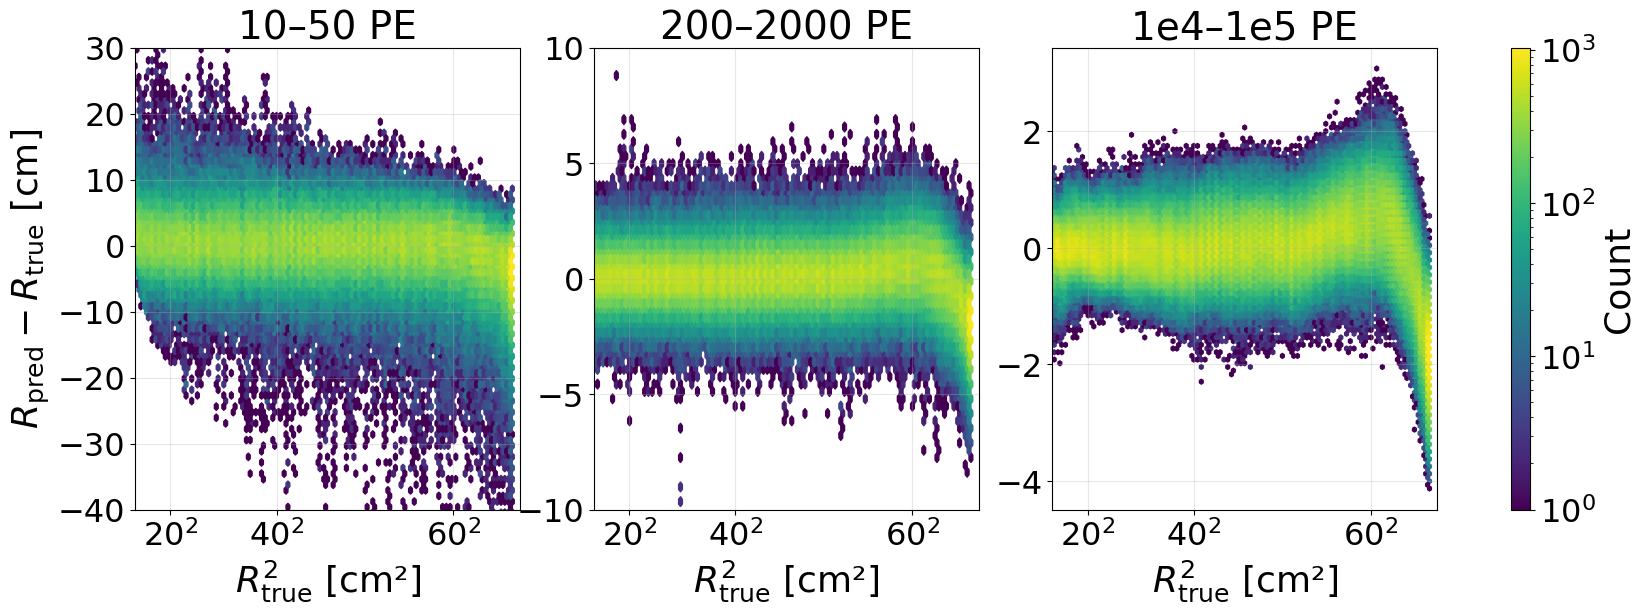

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import os

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 26,
    "axes.labelsize": 26,
    "axes.titlesize": 28,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 26
})

# --- Configuration ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
model_names = [f'ungrouped_{i}' for i in range(1, 11)]
area_keys = ['area_10_50', 'area_200_2000', 'area_1e4_1e5']
area_labels = ['10–50 PE', '200–2000 PE', '1e4–1e5 PE']
tick_vals = [20**2, 40**2, 60**2]
tick_labels = [r"$20^2$", r"$40^2$", r"$60^2$"]

# --- Load all results ---
combined_results = {key: [] for key in area_keys}
for model_name in model_names:
    path = os.path.join(data_dir, f"saved_data_{model_name}.npz")
    if not os.path.exists(path):
        continue
    with np.load(path) as data:
        area_test = data['area_test']
        pos_test = data['pos_test']
        pos_pred = data['pos_pred']
        radial_errors = data['radial_errors']

    area_ranges = {
        'area_10_50': (10, 50),
        'area_200_2000': (200, 2000),
        'area_1e4_1e5': (1e4, 1e5)
    }

    for key in area_keys:
        area_min, area_max = area_ranges[key]

        mask = (area_test >= area_min) & (area_test <= area_max)
        if not np.any(mask):
            continue
        combined_results[key].append({
            'pos_test': pos_test[mask],
            'pos_pred': pos_pred[mask],
            'radial_errors': radial_errors[mask]
        })

# --- Figure with only the top row ---
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.25)

for i, (key, label) in enumerate(zip(area_keys, area_labels)):
    ax = fig.add_subplot(gs[0, i])
    all_r_true2, all_r_diff = [], []

    for run in combined_results[key]:
        r_true = np.linalg.norm(run['pos_test'], axis=1)
        r_pred = np.linalg.norm(run['pos_pred'], axis=1)
        r_diff = r_pred - r_true
        all_r_true2.append(r_true**2)
        all_r_diff.append(r_diff)

    r_true2_concat = np.concatenate(all_r_true2)
    r_diff_concat = np.concatenate(all_r_diff)

    hb = ax.hexbin(r_true2_concat, r_diff_concat, gridsize=100, cmap='viridis', mincnt=1, norm=LogNorm())

    ax.set_title(label)
    ax.set_xlabel('$R_\\mathrm{true}^2$ [cm²]')
    if i == 0:
        ax.set_ylabel("$R_\\mathrm{pred} - R_\\mathrm{true}$ [cm]")
    ax.grid(alpha=0.3)
    #ax.axvline(x=60**2, color='red', linestyle='--', linewidth=1.5)
    ax.set_xlim(0, 66**2)

    if key == "area_10_50":
        ax.set_ylim(-40, 30)
    if key == "area_200_2000":
        ax.set_ylim(-10, 10)

    ax.set_xticks(tick_vals)
    ax.set_xticklabels(tick_labels)

# --- Shared colorbar ---
cax = fig.add_subplot(gs[0, 3])
cb = fig.colorbar(hb, cax=cax)
cb.set_label("Count")

plt.tight_layout()
#plt.savefig("ungrouped_rad_err_hexbin.png", dpi=300, bbox_inches='tight')
plt.show()


/scratch/local/jobs/32764848/ipykernel_2526899/1866605394.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Ungrouped")


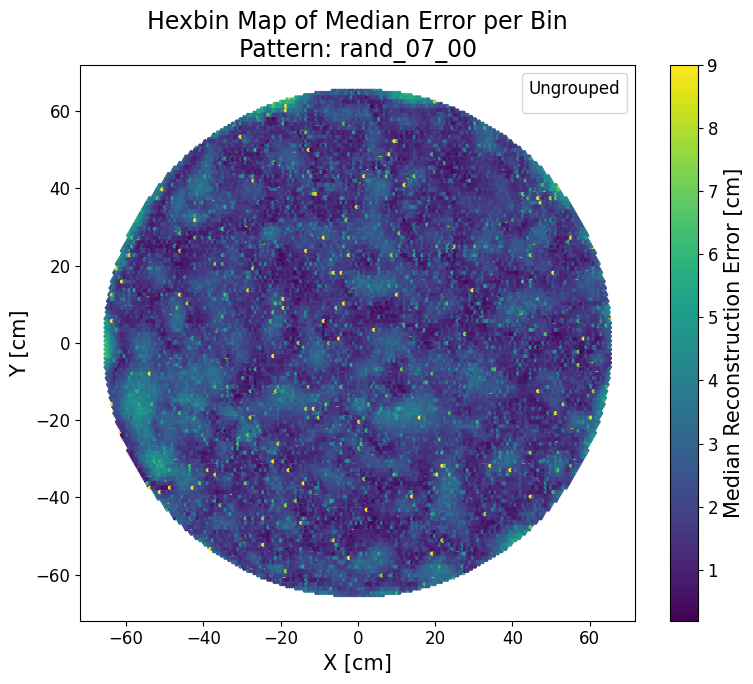

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
pattern_name = "rand_07_00"    # <-- Set your pattern name here
gridsize = 200                # Resolution of hexbin grid

# --- Load data ---
data_path = f"/scratch/midway3/nkoebelin/mux_data_new/saved_data_{pattern_name}.npz"
data = np.load(data_path)
pos_test = data["pos_test"]
abs_errors = data["abs_errors"]

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Coordinates and values to plot ---
x = pos_test[:, 0]
y = pos_test[:, 1]
values = abs_errors  # The quantity to average within each bin

# --- Plot hexbin: average error per bin ---
plt.figure(figsize=(8, 7))
hb = plt.hexbin(
    x, y,
    C=values,
    reduce_C_function=np.median,
    gridsize=gridsize,
    cmap='viridis',
    mincnt=1,  # Hide empty bins
    vmax=9
)

# --- Colorbar ---
cbar = plt.colorbar(hb)
cbar.set_label("Median Reconstruction Error [cm]")

# --- Labels and layout ---
plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")
plt.legend(title="Ungrouped")
plt.title(f"Hexbin Map of Median Error per Bin\nPattern: {pattern_name}")
plt.axis('equal')
plt.tight_layout()
#plt.show()
#plt.savefig("adj6_hexbin_median_errror.png", dpi=300)

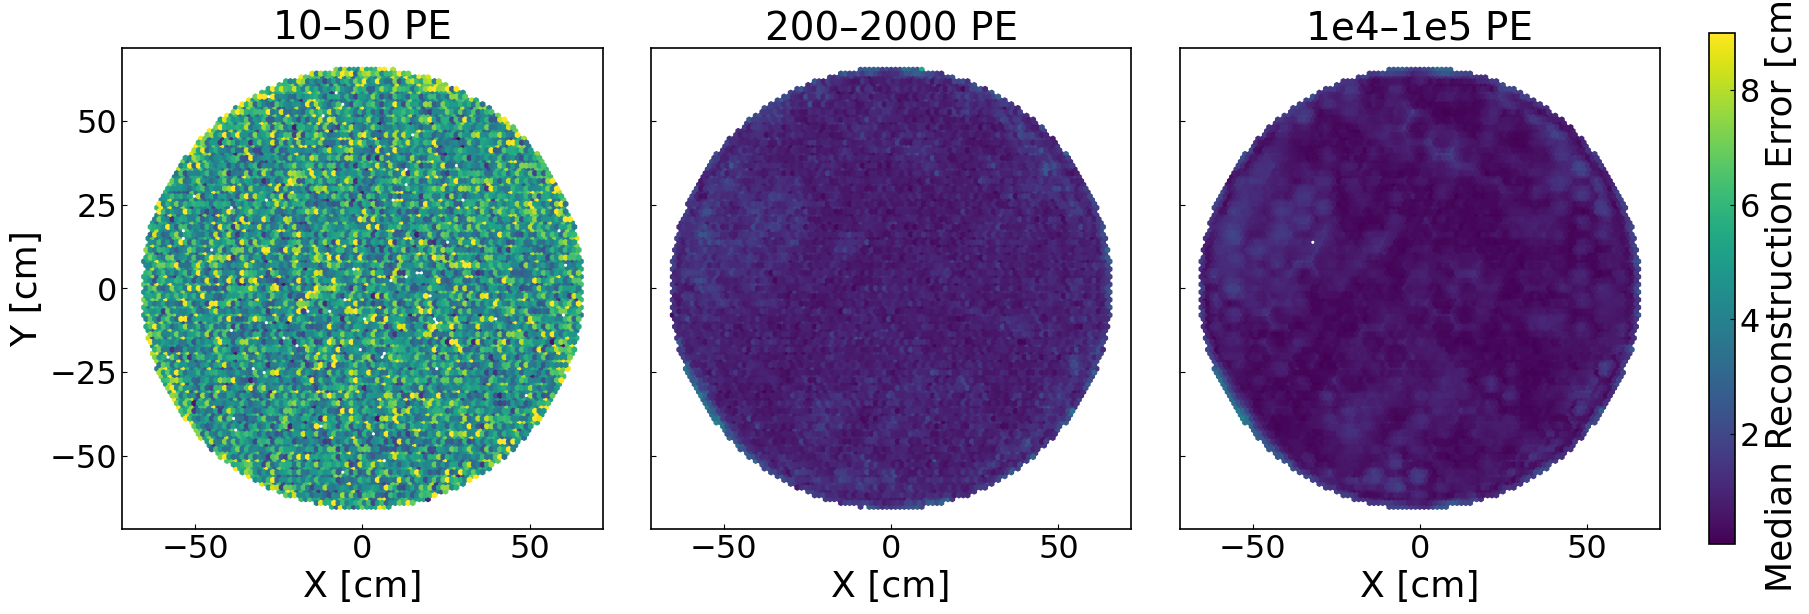

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# --- Font size setup to match reference layout ---
plt.rcParams.update({
    "font.size": 26,
    "axes.labelsize": 26,
    "axes.titlesize": 28,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 26
})

# --- Area configurations ---
area_keys = ['area_10_50', 'area_200_2000', 'area_1e4_1e5']
area_labels = ['10–50 PE', '200–2000 PE', '1e4–1e5 PE']

# --- Grid resolution and global vmax ---
gridsize = 100
vmax = 9  # consistent scale for all plots

# --- Create figure and axes ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, bottom=0.12, top=0.85)

# --- Loop through the three energy ranges ---
for ax, key, label in zip(axes, area_keys, area_labels):
    result = all_results[key]
    x = result["pos_test"][:, 0]
    y = result["pos_test"][:, 1]
    values = result["abs_errors"]

    hb = ax.hexbin(
        x, y,
        C=values,
        reduce_C_function=np.median,
        gridsize=gridsize,
        cmap='viridis',
        mincnt=1,
        vmax=vmax
    )

    ax.set_title(label)
    ax.set_xlabel("X [cm]")
    if ax is axes[0]:
        ax.set_ylabel("Y [cm]")
    ax.set_aspect("equal")
    #ax.grid(alpha=0.3)

# --- Shared colorbar ---
cbar = fig.colorbar(hb, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.025, pad=0.03)
cbar.set_label("Median Reconstruction Error [cm]")

# --- Main title ---
#fig.suptitle("Hexbin Map of Median Error per Bin (Ungrouped)", fontsize=16)

# --- Save or show ---
#plt.savefig("ungrouped_hexbin_median_error_all_ranges.png", dpi=300)
# plt.show()


In [58]:
from matplotlib import colors

# --- Count number of events per hexbin cell ---
for key, label in zip(area_keys, area_labels):
    result = all_results[key]
    x = result["pos_test"][:, 0]
    y = result["pos_test"][:, 1]

    # Create hexbin just for counting points (no color data)
    hb = plt.hexbin(
        x, y,
        gridsize=gridsize,
        cmap='viridis',
        mincnt=1,
        reduce_C_function=None  # counts only
    )
    counts = hb.get_array()
    print(f"\n{label}:")
    print("Bin counts (non-empty bins only):")
    print(np.mean(counts.astype(int)))

    plt.clf()  # Clear the figure to avoid memory buildup



10–50 PE:
Bin counts (non-empty bins only):
5.360612402246944

200–2000 PE:
Bin counts (non-empty bins only):
10.943429259218734

1e4–1e5 PE:
Bin counts (non-empty bins only):
11.03249452954048


<Figure size 640x480 with 0 Axes>

# Gain Fluctations

In [9]:
# Gain fluctuations & Broken PMTs

import numpy as np
import os
from tqdm import tqdm

# --- Configuration ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
mux_name = 'ungrouped'
file_path = os.path.join(data_dir, f"saved_data_{mux_name}_analysis.npz")

# Area test ranges (name used only as a label, no saving)
area_ranges = [
    (200, 2000, 'area_200_2000'),
    (10, 50, 'area_10_50'),
    (10, 1e5, 'area_10_1e5'),
    (1e4, 1e5, 'area_1e4_1e5')
]

# Suffixes for each test condition
variation_keys = {
    #"": "pos_pred",  # baseline
    "gain": "pos_pred_gain",
    "off_1": "pos_pred_off_1",
    "off_2": "pos_pred_off_2",
    "off_5": "pos_pred_off_5",
    "off_10": "pos_pred_off_10"
}

# Percentile function
def compute_percentiles(errors, percentiles=[68, 90, 95, 99]):
    return {f'{p}th_percentile': np.percentile(errors, p) for p in percentiles}

# Load mux pattern info
muxing_patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)
n_groups = muxing_patterns[mux_name].shape[0]

# Load all data
with np.load(file_path) as data:
    area_test = data['area_test']
    pos_test = data['pos_test']
    stored_data = dict(data)

    # Load PMT-off indices
    pmts_off = {}
    for n_off in [1, 2, 5, 10]:
        key = f"pmts_off_{n_off}"
        if key in data:
            pmts_off[n_off] = data[key]


# Analyze each condition and area range
all_results = {}
for variant, pred_key in variation_keys.items():
    if pred_key not in stored_data:
        print(f"Skipping variant '{variant}' – {pred_key} not found.")
        continue

    pos_pred = stored_data[pred_key]
    abs_errors = np.linalg.norm(pos_pred - pos_test, axis=1)
    radial_errors = np.linalg.norm(pos_pred, axis=1) - np.linalg.norm(pos_test, axis=1)

    for area_min, area_max, label in area_ranges:
        mask = (area_test >= area_min) & (area_test <= area_max)
        if not np.any(mask):
            print(f"No events in area range {area_min}-{area_max} for variant '{variant}'")
            continue

        filtered_errors = abs_errors[mask]
        filtered_radial = radial_errors[mask]
        filtered_area = area_test[mask]
        filtered_pos_test = pos_test[mask]
        filtered_pos_pred = pos_pred[mask]

        percentiles = compute_percentiles(filtered_errors)
        result = {
            'mux_name': mux_name,
            'n_groups': n_groups,
            'variant': variant or 'baseline',
            'mean_error': filtered_errors.mean(),
            'median_error': np.median(filtered_errors),
            'std_error': filtered_errors.std(),
            **percentiles,
            'abs_errors': filtered_errors,
            'radial_errors': filtered_radial,
            'area_test': filtered_area,
            'pos_test': filtered_pos_test,
            'pos_pred': filtered_pos_pred
        }

        result_key = f"{variant}_{label}" if variant else label
        all_results[result_key] = result

# Display summary
for label, stats in all_results.items():
    print(f"\n--- Results for: {label} ---")
    for k, v in stats.items():
        if isinstance(v, np.ndarray):
            print(f"{k}: array shape {v.shape}")
        elif isinstance(v, float):
            print(f"{k}: {v:.3f}")
        else:
            print(f"{k}: {v}")



--- Results for: gain_area_200_2000 ---
mux_name: ungrouped
n_groups: 253
variant: gain
mean_error: 1.2746121883392334
median_error: 1.1119269132614136
std_error: 0.8112286329269409
68th_percentile: 1.4883129596710205
90th_percentile: 2.361358880996704
95th_percentile: 2.832904815673828
99th_percentile: 3.8670332431793213
abs_errors: array shape (99911,)
radial_errors: array shape (99911,)
area_test: array shape (99911,)
pos_test: array shape (99911, 2)
pos_pred: array shape (99911, 2)

--- Results for: gain_area_10_50 ---
mux_name: ungrouped
n_groups: 253
variant: gain
mean_error: 5.756443977355957
median_error: 4.753244876861572
std_error: 4.545473098754883
68th_percentile: 6.429116725921631
90th_percentile: 10.567139625549316
95th_percentile: 13.379096031188965
99th_percentile: 22.327058792114258
abs_errors: array shape (48539,)
radial_errors: array shape (48539,)
area_test: array shape (48539,)
pos_test: array shape (48539, 2)
pos_pred: array shape (48539, 2)

--- Results for: gai

In [7]:
with np.load(os.path.join(data_dir, f"saved_data_{mux_name}_analysis.npz")) as f:
    print([key for key in f.keys() if key.startswith("pmts_off_")])


['pmts_off_1', 'pmts_off_2', 'pmts_off_5', 'pmts_off_10']


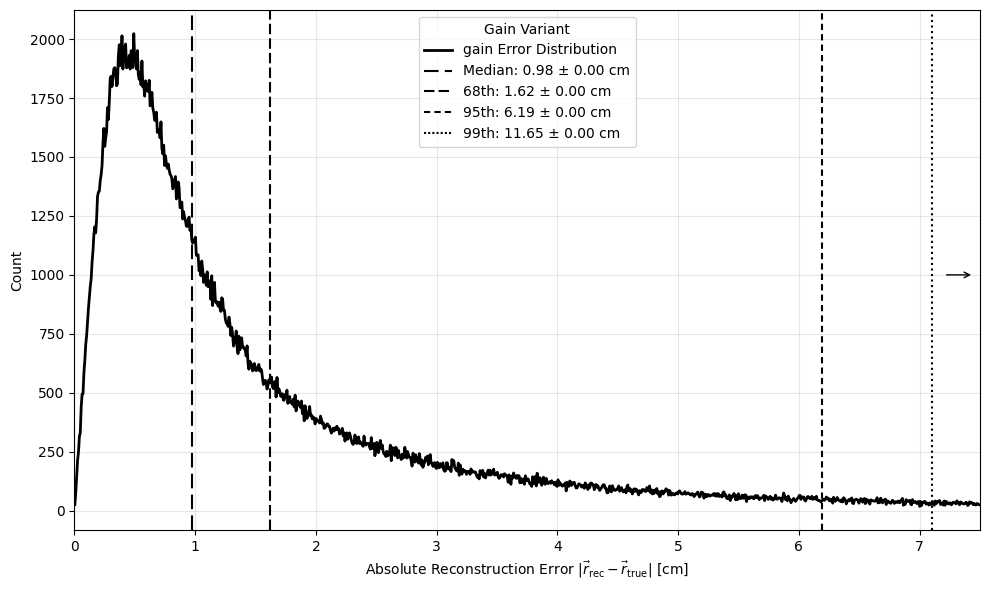

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# --- Configuration ---
area_key = 'area_10_1e5'
variant = 'gain'  # Change this to any of: 'gain', 'off_1', 'off_2', 'off_5', 'off_10'
bins = np.linspace(0, 7.5, 1000)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# --- Collect histogram and metrics from noise-injected run ---
abs_errors = all_results[f"{variant}_{area_key}"]["abs_errors"]
hist, _ = np.histogram(abs_errors, bins=bins)

# --- Compute percentiles and deviation (single run, so uncertainty is 0) ---
percentile_stats = {
    "Median": (np.median(abs_errors), 0.0),
    "68th": (np.percentile(abs_errors, 68), 0.0),
    "95th": (np.percentile(abs_errors, 95), 0.0),
    "99th": (np.percentile(abs_errors, 99), 0.0)
}

# --- Plot ---
plt.figure(figsize=(10, 6))

# Plot histogram
plt.plot(bin_centers, hist, color='black', linewidth=2, label=f"{variant} Error Distribution")

# Add vertical percentile lines + legend entries
handles = [Line2D([], [], color='black', linewidth=2, label=f"{variant} Error Distribution")]
linestyles = {
    'Median': (0, (7, 3)),
    '68th': (0, (5, 2)),
    '95th': (0, (3, 2)),
    '99th': (0, (1, 1))
}

for label, (value, uncertainty) in percentile_stats.items():
    linestyle = linestyles[label]
    plt.axvline(value, color='black', linestyle=linestyle, linewidth=1.5)
    entry = f"{label}: {value:.2f} ± {uncertainty:.2f} cm"
    handles.append(Line2D([], [], color='black', linestyle=linestyle, linewidth=1.5, label=entry))

plt.axvline(7.1, color='black', linestyle=":", linewidth=1.5)
plt.annotate('', xy=(7.45, 1000), xytext=(7.2, 1000), arrowprops=dict(arrowstyle='->', color='black', lw=1))

# --- Formatting ---
plt.xlabel(r"Absolute Reconstruction Error $|\vec{r}_\mathrm{rec} - \vec{r}_\mathrm{true}|$ [cm]")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.xlim(0, 7.5)
plt.legend(title=f"{variant.capitalize()} Variant", handles=handles)
plt.tight_layout()
# plt.savefig(f"{variant}_error_distribution.png", dpi=300)
# plt.show()


In [20]:
import numpy as np
import os

# --- Paths ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
mux_name = 'ungrouped'
baseline_path = os.path.join(data_dir, f"saved_data_{mux_name}.npz")
analysis_path = os.path.join(data_dir, f"saved_data_{mux_name}_analysis.npz")

# --- Load baseline results ---
with np.load(baseline_path) as data:
    area_test = data["area_test"]
    abs_errors = data["abs_errors"]
    radial_errors = data["radial_errors"]
    pos_test = data["pos_test"]
    pos_pred = data["pos_pred"]

all_results_baseline = {}
area_key = "area_10_1e5"
mask = (area_test >= 10) & (area_test <= 1e5)
all_results_baseline[area_key] = {
    "abs_errors": abs_errors[mask],
    "radial_errors": radial_errors[mask],
    "pos_test": pos_test[mask],
    "pos_pred": pos_pred[mask]
}

# --- Load noise variant results ---
with np.load(analysis_path) as data:
    area_test = data["area_test"]
    pos_test = data["pos_test"]
    abs_errors_gain = data["abs_errors_gain"]
    pos_pred_gain = data["pos_pred_gain"]

all_results_variants = {}
mask = (area_test >= 10) & (area_test <= 1e5)
all_results_variants["gain_area_10_1e5"] = {
    "abs_errors": abs_errors_gain[mask],
    "pos_pred": pos_pred_gain[mask],
    "pos_test": pos_test[mask]
}

# --- Access errors ---
errors_baseline = all_results_baseline[area_key]["abs_errors"]
errors_gain = all_results_variants[variant_key]["abs_errors"]

# --- Helper ---
def summarize_percentiles(name, errors):
    print(f"\n{name} (n = {len(errors)}):")
    for p in [50, 68, 90, 95, 99]:
        val = np.percentile(errors, p)
        print(f"  {p}th percentile: {val:.3f} cm")

# --- Summary Output ---
summarize_percentiles("Original (Ungrouped)", errors_baseline)
summarize_percentiles("Gain Noise (2%)", errors_gain)



Original (Ungrouped) (n = 377340):
  50th percentile: 0.974 cm
  68th percentile: 1.622 cm
  90th percentile: 4.189 cm
  95th percentile: 6.173 cm
  99th percentile: 11.594 cm

Gain Noise (2%) (n = 377340):
  50th percentile: 0.978 cm
  68th percentile: 1.624 cm
  90th percentile: 4.197 cm
  95th percentile: 6.192 cm
  99th percentile: 11.653 cm


Here is the relative difference between the **original** and the **gain noise (2%)** results for each percentile, calculated as:

$$
\text{Relative Difference} = \frac{\text{Gain Noise} - \text{Original}}{\text{Original}} \times 100\%
$$

| Percentile | Original \[cm] | Gain Noise \[cm] | Relative Difference |
| ---------- | -------------- | ---------------- | ------------------- |
| 50th       | 0.974          | 0.978            | **+0.41%**          |
| 68th       | 1.622          | 1.624            | **+0.12%**          |
| 90th       | 4.189          | 4.197            | **+0.19%**          |
| 95th       | 6.173          | 6.192            | **+0.31%**          |
| 99th       | 11.594         | 11.653           | **+0.51%**          |

These differences are very small, indicating that 2% gain fluctuations have a **negligible effect** on absolute error percentiles in this test.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

# --- Voigt function ---
def voigt(x, x0, sigma, gamma, A):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- Configuration ---
variant = 'gain'  # Set to one of: 'gain', 'off_1', 'off_2', 'off_5', 'off_10'
area_key = 'area_10_1e5'
bins = np.linspace(-6, 6, 1000)

# --- Extract positions ---
data = all_results[f"{variant}_{area_key}"]
pos_test = data["pos_test"]
pos_pred = data["pos_pred"]
abs_errors = data["abs_errors"]

# --- Apply threshold mask (optional) ---
threshold = np.percentile(abs_errors, 100)
mask = abs_errors < threshold
delta = pos_pred - pos_test
delta_x = delta[mask, 0]
delta_y = delta[mask, 1]

# --- Fit wrapper ---
def fit_voigt(delta_vals):
    counts, edges = np.histogram(delta_vals, bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])
    sigma_y = np.sqrt(np.maximum(counts, 1))

    p0 = [0, 1, 1, np.max(counts)]
    try:
        popt, _ = curve_fit(voigt, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
        x0, sigma, gamma, A = popt
        fwhm = 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2.35482 * sigma)**2)
        return np.array(popt), fwhm
    except RuntimeError:
        print("Fit failed.")
        return np.full(4, np.nan), np.nan

# --- Fit both Δx and Δy ---
fit_x, fwhm_x = fit_voigt(delta_x)
fit_y, fwhm_y = fit_voigt(delta_y)

# --- Summary printout ---
def summarize(name, fit, fwhm):
    param_names = ["μ", "σ", "γ", "A"]
    print(f"\n{name} FIT RESULTS (Voigt profile):")
    for i, pname in enumerate(param_names):
        print(f"{pname}: {fit[i]:.3f}")
    print(f"FWHM: {fwhm:.3f}")

summarize("Δx", fit_x, fwhm_x)
summarize("Δy", fit_y, fwhm_y)



Δx FIT RESULTS (Voigt profile):
μ: -0.111
σ: 0.000
γ: 0.573
A: 4683.316
FWHM: 1.146

Δy FIT RESULTS (Voigt profile):
μ: 0.004
σ: 0.174
γ: 0.579
A: 4690.823
FWHM: 1.295


In [11]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import wofz

# --- Voigt function ---
def voigt(x, x0, sigma, gamma, A):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- Fitting function ---
def fit_voigt(delta_vals, bins=np.linspace(-6, 6, 1000)):
    counts, edges = np.histogram(delta_vals, bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])
    sigma_y = np.sqrt(np.maximum(counts, 1))
    p0 = [0, 1, 1, max(counts)]
    try:
        popt, _ = curve_fit(voigt, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
        x0, sigma, gamma, A = popt
        fwhm = 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2.35482 * sigma)**2)
        return popt, fwhm
    except RuntimeError:
        print("Fit failed.")
        return [np.nan]*4, np.nan

# --- Summary printing ---
def summarize_fit(label, fit_x, fwhm_x, fit_y, fwhm_y):
    print(f"\n=== Voigt Fit Results: {label} ===")
    param_names = ["μ", "σ", "γ", "A"]
    for i, name in enumerate(param_names):
        print(f"Δx {name}: {fit_x[i]:.3f} | Δy {name}: {fit_y[i]:.3f}")
    print(f"Δx FWHM: {fwhm_x:.3f}")
    print(f"Δy FWHM: {fwhm_y:.3f}")

# --- Load both datasets ---
original_path = "/scratch/midway3/nkoebelin/mux_data_new/saved_data_ungrouped.npz"
gain_path = "/scratch/midway3/nkoebelin/mux_data_new/saved_data_ungrouped_analysis.npz"
area_key = "area_10_1e5"

# --- Load original ---
with np.load(original_path) as data:
    mask = (data['area_test'] >= 10) & (data['area_test'] <= 1e5)
    pos_test_orig = data['pos_test'][mask]
    pos_pred_orig = data['pos_pred'][mask]
    abs_errors_orig = data['abs_errors'][mask]

# --- Load gain variation ---
with np.load(gain_path) as data:
    mask = (data['area_test'] >= 10) & (data['area_test'] <= 1e5)
    pos_test_gain = data['pos_test'][mask]
    pos_pred_gain = data['pos_pred_gain'][mask]
    abs_errors_gain = data['abs_errors_gain'][mask]

# --- Compute deltas and fit ---
delta_x_orig = pos_pred_orig[:, 0] - pos_test_orig[:, 0]
delta_y_orig = pos_pred_orig[:, 1] - pos_test_orig[:, 1]
fit_x_orig, fwhm_x_orig = fit_voigt(delta_x_orig)
fit_y_orig, fwhm_y_orig = fit_voigt(delta_y_orig)

delta_x_gain = pos_pred_gain[:, 0] - pos_test_gain[:, 0]
delta_y_gain = pos_pred_gain[:, 1] - pos_test_gain[:, 1]
fit_x_gain, fwhm_x_gain = fit_voigt(delta_x_gain)
fit_y_gain, fwhm_y_gain = fit_voigt(delta_y_gain)

# --- Print comparison ---
summarize_fit("Original Ungrouped", fit_x_orig, fwhm_x_orig, fit_y_orig, fwhm_y_orig)
summarize_fit("Gain Fluctuations (2%)", fit_x_gain, fwhm_x_gain, fit_y_gain, fwhm_y_gain)



=== Voigt Fit Results: Original Ungrouped ===
Δx μ: -0.110 | Δy μ: 0.003
Δx σ: 0.000 | Δy σ: 0.175
Δx γ: 0.570 | Δy γ: 0.577
Δx A: 4680.243 | Δy A: 4690.390
Δx FWHM: 1.141
Δy FWHM: 1.293

=== Voigt Fit Results: Gain Fluctuations (2%) ===
Δx μ: -0.111 | Δy μ: 0.004
Δx σ: 0.000 | Δy σ: 0.174
Δx γ: 0.573 | Δy γ: 0.579
Δx A: 4683.316 | Δy A: 4690.823
Δx FWHM: 1.146
Δy FWHM: 1.295


In [5]:
import numpy as np
import os

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_ungrouped.npz"
gain_file = "saved_data_ungrouped_analysis.npz"

# --- Energy ranges to analyze ---
area_ranges = [
    (10, 1e5, "10–1e5 PE"),
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
]

# --- Helper: Single-run baseline percentiles ---
def get_baseline_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
        errors = data["abs_errors"][mask]
        return {p: np.percentile(errors, p) for p in [50, 68, 95, 99]}

# --- Helper: Gain noise percentiles ---
def get_gain_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, gain_file)) as data:
        mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
        errors = np.linalg.norm(data["pos_pred_gain"][mask] - data["pos_test"][mask], axis=1)
        return {p: np.percentile(errors, p) for p in [50, 68, 95, 99]}

# --- Run comparison ---
for area_min, area_max, label in area_ranges:
    baseline = get_baseline_percentiles(area_min, area_max)
    gain = get_gain_percentiles(area_min, area_max)

    print(f"\n--- {label} ---")
    for p in [50, 68, 95, 99]:
        print(f"{p}th percentile: Baseline = {baseline[p]:.3f} cm, Gain = {gain[p]:.3f} cm")



--- 10–1e5 PE ---
50th percentile: Baseline = 0.974 cm, Gain = 0.978 cm
68th percentile: Baseline = 1.622 cm, Gain = 1.624 cm
95th percentile: Baseline = 6.173 cm, Gain = 6.192 cm
99th percentile: Baseline = 11.594 cm, Gain = 11.653 cm

--- 10–50 PE ---
50th percentile: Baseline = 4.735 cm, Gain = 4.753 cm
68th percentile: Baseline = 6.403 cm, Gain = 6.429 cm
95th percentile: Baseline = 13.296 cm, Gain = 13.379 cm
99th percentile: Baseline = 22.112 cm, Gain = 22.327 cm

--- 200–2000 PE ---
50th percentile: Baseline = 1.108 cm, Gain = 1.112 cm
68th percentile: Baseline = 1.482 cm, Gain = 1.488 cm
95th percentile: Baseline = 2.819 cm, Gain = 2.833 cm
99th percentile: Baseline = 3.856 cm, Gain = 3.867 cm

--- 1e4–1e5 PE ---
50th percentile: Baseline = 0.518 cm, Gain = 0.521 cm
68th percentile: Baseline = 0.706 cm, Gain = 0.709 cm
95th percentile: Baseline = 1.532 cm, Gain = 1.533 cm
99th percentile: Baseline = 2.301 cm, Gain = 2.293 cm


In [5]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = os.path.join(data_dir, "saved_data_ungrouped.npz")
gain_file = os.path.join(data_dir, "saved_data_ungrouped_analysis.npz")
area_min, area_max = 10, 1e5

# --- Helper function ---
def compute_percentiles(errors):
    percentiles = [50, 68, 95, 99]
    return {f"{p}th": np.percentile(errors, p) for p in percentiles}

# --- Load baseline data ---
with np.load(baseline_file) as data_base:
    area_base = data_base["area_test"]
    radial_base = data_base["radial_errors"]
    mask_base = (area_base >= area_min) & (area_base <= area_max)
    radial_base = radial_base[mask_base]
    n_base = len(radial_base)

# --- Load gain fluctuation data ---
with np.load(gain_file) as data_gain:
    area_gain = data_gain["area_test"]
    radial_gain = data_gain["radial_errors_gain"]
    mask_gain = (area_gain >= area_min) & (area_gain <= area_max)
    radial_gain = radial_gain[mask_gain]
    n_gain = len(radial_gain)

# --- Compute and display ---
base_percentiles = compute_percentiles(radial_base)
gain_percentiles = compute_percentiles(radial_gain)

print(f"Original (Ungrouped) (n = {n_base}):")
for p, val in base_percentiles.items():
    print(f"  {p} percentile: {val:.3f} cm")

print(f"\nGain Noise (2%) (n = {n_gain}):")
for p, val in gain_percentiles.items():
    print(f"  {p} percentile: {val:.3f} cm")

# --- Optional: Compute relative differences ---
print("\nRelative Differences (Gain vs Baseline):")
for p in base_percentiles:
    base_val = base_percentiles[p]
    gain_val = gain_percentiles[p]
    delta_pct = 100 * (gain_val - base_val) / base_val
    print(f"  {p}: Δ = {gain_val - base_val:.3f} cm ({delta_pct:+.2f}%)")


Original (Ungrouped) (n = 377340):
  50th percentile: 0.111 cm
  68th percentile: 0.504 cm
  95th percentile: 2.741 cm
  99th percentile: 5.902 cm

Gain Noise (2%) (n = 377340):
  50th percentile: 0.113 cm
  68th percentile: 0.505 cm
  95th percentile: 2.739 cm
  99th percentile: 5.949 cm

Relative Differences (Gain vs Baseline):
  50th: Δ = 0.002 cm (+1.68%)
  68th: Δ = 0.001 cm (+0.26%)
  95th: Δ = -0.002 cm (-0.07%)
  99th: Δ = 0.047 cm (+0.80%)


In [6]:
import numpy as np
import os

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_ungrouped.npz"
gain_file = "saved_data_ungrouped_analysis.npz"

# --- Energy ranges to analyze ---
area_ranges = [
    (10, 1e5, "10–1e5 PE"),
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
]

# --- Helper: Single-run baseline radial percentiles ---
def get_baseline_radial_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        area = data["area_test"]
        radial = data["radial_errors"]
        mask = (area >= area_min) & (area <= area_max)
        return {p: np.percentile(radial[mask], p) for p in [50, 68, 95, 99]}

# --- Helper: Gain noise radial percentiles ---
def get_gain_radial_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, gain_file)) as data:
        area = data["area_test"]
        radial = data["radial_errors_gain"]
        mask = (area >= area_min) & (area <= area_max)
        return {p: np.percentile(radial[mask], p) for p in [50, 68, 95, 99]}

# --- Compare baseline and gain noise for each energy range ---
for area_min, area_max, label in area_ranges:
    baseline = get_baseline_radial_percentiles(area_min, area_max)
    gain = get_gain_radial_percentiles(area_min, area_max)

    print(f"\n--- {label} ---")
    for p in [50, 68, 95, 99]:
        print(f"{p}th percentile: Baseline = {baseline[p]:.3f} cm, Gain = {gain[p]:.3f} cm")



--- 10–1e5 PE ---
50th percentile: Baseline = 0.111 cm, Gain = 0.113 cm
68th percentile: Baseline = 0.504 cm, Gain = 0.505 cm
95th percentile: Baseline = 2.741 cm, Gain = 2.739 cm
99th percentile: Baseline = 5.902 cm, Gain = 5.949 cm

--- 10–50 PE ---
50th percentile: Baseline = -0.179 cm, Gain = -0.179 cm
68th percentile: Baseline = 1.632 cm, Gain = 1.651 cm
95th percentile: Baseline = 6.668 cm, Gain = 6.724 cm
99th percentile: Baseline = 10.520 cm, Gain = 10.691 cm

--- 200–2000 PE ---
50th percentile: Baseline = 0.139 cm, Gain = 0.144 cm
68th percentile: Baseline = 0.589 cm, Gain = 0.593 cm
95th percentile: Baseline = 1.910 cm, Gain = 1.913 cm
99th percentile: Baseline = 2.870 cm, Gain = 2.881 cm

--- 1e4–1e5 PE ---
50th percentile: Baseline = 0.105 cm, Gain = 0.107 cm
68th percentile: Baseline = 0.339 cm, Gain = 0.340 cm
95th percentile: Baseline = 1.008 cm, Gain = 1.022 cm
99th percentile: Baseline = 1.497 cm, Gain = 1.509 cm


In [7]:
import numpy as np
import os

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_ungrouped.npz"
gain_file = "saved_data_ungrouped_analysis.npz"

# --- Energy ranges to analyze ---
area_ranges = [
    (10, 1e5, "10–1e5 PE"),
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
]

# --- Helper: Signed + abs baseline radial percentiles ---
def get_baseline_radial_stats(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        radial = data["radial_errors"]
        area = data["area_test"]
        mask = (area >= area_min) & (area <= area_max)
        vals = radial[mask]
        abs_vals = np.abs(vals)
        return {
            "signed_median": np.median(vals),
            "abs_median": np.median(abs_vals),
            "abs_68": np.percentile(abs_vals, 68),
            "abs_95": np.percentile(abs_vals, 95),
            "abs_99": np.percentile(abs_vals, 99)
        }

# --- Helper: Signed + abs gain variation radial percentiles ---
def get_gain_radial_stats(area_min, area_max):
    with np.load(os.path.join(data_dir, gain_file)) as data:
        radial = data["radial_errors_gain"]
        area = data["area_test"]
        mask = (area >= area_min) & (area <= area_max)
        vals = radial[mask]
        abs_vals = np.abs(vals)
        return {
            "signed_median": np.median(vals),
            "abs_median": np.median(abs_vals),
            "abs_68": np.percentile(abs_vals, 68),
            "abs_95": np.percentile(abs_vals, 95),
            "abs_99": np.percentile(abs_vals, 99)
        }

# --- Compare ---
for area_min, area_max, label in area_ranges:
    baseline = get_baseline_radial_stats(area_min, area_max)
    gain = get_gain_radial_stats(area_min, area_max)

    print(f"\n--- {label} ---")
    print(f"Signed Median: Baseline = {baseline['signed_median']:.3f} cm, Gain = {gain['signed_median']:.3f} cm")
    print(f"Abs Median:    Baseline = {baseline['abs_median']:.3f} cm, Gain = {gain['abs_median']:.3f} cm")
    for p in [68, 95, 99]:
        print(f"Abs {p}th:     Baseline = {baseline[f'abs_{p}']:.3f} cm, Gain = {gain[f'abs_{p}']:.3f} cm")



--- 10–1e5 PE ---
Signed Median: Baseline = 0.111 cm, Gain = 0.113 cm
Abs Median:    Baseline = 0.600 cm, Gain = 0.602 cm
Abs 68th:     Baseline = 1.048 cm, Gain = 1.051 cm
Abs 95th:     Baseline = 4.243 cm, Gain = 4.254 cm
Abs 99th:     Baseline = 8.380 cm, Gain = 8.434 cm

--- 10–50 PE ---
Signed Median: Baseline = -0.179 cm, Gain = -0.179 cm
Abs Median:    Baseline = 2.716 cm, Gain = 2.723 cm
Abs 68th:     Baseline = 4.108 cm, Gain = 4.119 cm
Abs 95th:     Baseline = 9.693 cm, Gain = 9.729 cm
Abs 99th:     Baseline = 16.175 cm, Gain = 16.302 cm

--- 200–2000 PE ---
Signed Median: Baseline = 0.139 cm, Gain = 0.144 cm
Abs Median:    Baseline = 0.664 cm, Gain = 0.668 cm
Abs 68th:     Baseline = 1.007 cm, Gain = 1.013 cm
Abs 95th:     Baseline = 2.310 cm, Gain = 2.325 cm
Abs 99th:     Baseline = 3.362 cm, Gain = 3.396 cm

--- 1e4–1e5 PE ---
Signed Median: Baseline = 0.105 cm, Gain = 0.107 cm
Abs Median:    Baseline = 0.327 cm, Gain = 0.329 cm
Abs 68th:     Baseline = 0.506 cm, Gain = 0

In [11]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_ungrouped.npz"  # Single ungrouped run
gain_file = "saved_data_ungrouped_analysis.npz"

# --- Area ranges to evaluate ---
area_ranges = [
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
    (10, 1e5, "10–1e5 PE")
]

r_fid = 61.35

# --- Baseline containment leakage ---
def compute_baseline_leakage(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        area = data["area_test"]
        pos_test = data["pos_test"]
        pos_pred = data["pos_pred"]

        r_true = np.linalg.norm(pos_test, axis=1)
        r_pred = np.linalg.norm(pos_pred, axis=1)

        mask_area = (area >= area_min) & (area <= area_max)
        mask_outer = r_true >= r_fid
        mask = mask_area & mask_outer

        if not np.any(mask):
            return None

        n_outer = np.sum(mask)
        n_leak = np.sum(r_pred[mask] < r_fid)
        return 100 * n_leak / n_outer

# --- Gain fluctuation containment leakage ---
def compute_gain_leakage(area_min, area_max):
    with np.load(os.path.join(data_dir, gain_file)) as data:
        area = data["area_test"]
        pos_test = data["pos_test"]
        pos_pred = data["pos_pred_gain"]

        r_true = np.linalg.norm(pos_test, axis=1)
        r_pred = np.linalg.norm(pos_pred, axis=1)

        mask_area = (area >= area_min) & (area <= area_max)
        mask_outer = r_true >= r_fid
        mask = mask_area & mask_outer

        if not np.any(mask):
            return None

        n_outer = np.sum(mask)
        n_leak = np.sum(r_pred[mask] < r_fid)
        return 100 * n_leak / n_outer

# --- Evaluate and compare ---
for area_min, area_max, label in area_ranges:
    baseline = compute_baseline_leakage(area_min, area_max)
    gain = compute_gain_leakage(area_min, area_max)

    print(f"\n--- {label} ---")
    if baseline is not None:
        print(f"Baseline: {baseline:.2f}%")
    else:
        print("Baseline: No valid data.")
    if gain is not None:
        print(f"Gain Noise: {gain:.2f}%")
    else:
        print("Gain Noise: No valid data.")



--- 10–50 PE ---
Baseline: 55.53%
Gain Noise: 55.55%

--- 200–2000 PE ---
Baseline: 9.36%
Gain Noise: 9.40%

--- 1e4–1e5 PE ---
Baseline: 1.14%
Gain Noise: 1.28%

--- 10–1e5 PE ---
Baseline: 14.73%
Gain Noise: 14.87%


# Broken PMTs


In [12]:
import numpy as np
import os

# --- Load saved analysis file ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
analysis_file = "saved_data_ungrouped_analysis.npz"

with np.load(os.path.join(data_dir, analysis_file)) as data:
    for n_off in [1, 2, 5, 10]:
        key = f"pmts_off_{n_off}"
        if key in data:
            print(f"\nPMTs turned off for {n_off} missing PMT(s): {data[key]}")
        else:
            print(f"\nKey '{key}' not found in the file.")



PMTs turned off for 1 missing PMT(s): [67]

PMTs turned off for 2 missing PMT(s): [53 13]

PMTs turned off for 5 missing PMT(s): [248 168 127  83 216]

PMTs turned off for 10 missing PMT(s): [ 83 136 248 192 204 226 149 155 138 212]


In [5]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import wofz

# --- Voigt function ---
def voigt(x, x0, sigma, gamma, A):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- Fitting function ---
def fit_voigt(delta_vals, bins=np.linspace(-6, 6, 1000)):
    counts, edges = np.histogram(delta_vals, bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])
    sigma_y = np.sqrt(np.maximum(counts, 1))
    p0 = [0, 1, 1, max(counts)]
    try:
        popt, _ = curve_fit(voigt, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
        x0, sigma, gamma, A = popt
        fwhm = 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2.35482 * sigma)**2)
        return popt, fwhm
    except RuntimeError:import numpy as np
import os

# --- Load saved analysis file ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
analysis_file = "saved_data_ungrouped_analysis.npz"

with np.load(os.path.join(data_dir, analysis_file)) as data:
    for n_off in [1, 2, 5, 10]:
        key = f"pmts_off_{n_off}"
        if key in data:
            print(f"\nPMTs turned off for {n_off} missing PMT(s): {data[key]}")
        else:
            print(f"\nKey '{key}' not found in the file.")

        print("Fit failed.")
        return [np.nan]*4, np.nan

# --- Summary printing ---
def summarize_fit(label, fit_x, fwhm_x, fit_y, fwhm_y):
    print(f"\n=== Voigt Fit Results: {label} ===")
    param_names = ["μ", "σ", "γ", "A"]
    for i, name in enumerate(param_names):
        print(f"Δx {name}: {fit_x[i]:.3f} | Δy {name}: {fit_y[i]:.3f}")
    print(f"Δx FWHM: {fwhm_x:.3f}")
    print(f"Δy FWHM: {fwhm_y:.3f}")

# --- Load datasets ---
original_path = "/scratch/midway3/nkoebelin/mux_data_new/saved_data_ungrouped.npz"
analysis_path = "/scratch/midway3/nkoebelin/mux_data_new/saved_data_ungrouped_analysis.npz"
area_min, area_max = 10, 1e5

# --- Load original baseline data ---
with np.load(original_path) as data:
    mask = (data['area_test'] >= area_min) & (data['area_test'] <= area_max)
    pos_test_orig = data['pos_test'][mask]
    pos_pred_orig = data['pos_pred'][mask]

delta_x_orig = pos_pred_orig[:, 0] - pos_test_orig[:, 0]
delta_y_orig = pos_pred_orig[:, 1] - pos_test_orig[:, 1]
fit_x_orig, fwhm_x_orig = fit_voigt(delta_x_orig)
fit_y_orig, fwhm_y_orig = fit_voigt(delta_y_orig)

summarize_fit("Original Ungrouped", fit_x_orig, fwhm_x_orig, fit_y_orig, fwhm_y_orig)

# --- Load and compare all broken PMT cases ---
with np.load(analysis_path) as data:
    for n_off in [1, 2, 5, 10]:
        pos_pred_off = data[f'pos_pred_off_{n_off}'][mask]
        pos_test_off = data['pos_test'][mask]

        delta_x = pos_pred_off[:, 0] - pos_test_off[:, 0]
        delta_y = pos_pred_off[:, 1] - pos_test_off[:, 1]

        fit_x, fwhm_x = fit_voigt(delta_x)
        fit_y, fwhm_y = fit_voigt(delta_y)

        summarize_fit(f"Broken PMTs (n_off = {n_off})", fit_x, fwhm_x, fit_y, fwhm_y)



=== Voigt Fit Results: Original Ungrouped ===
Δx μ: -0.110 | Δy μ: 0.003
Δx σ: 0.000 | Δy σ: 0.175
Δx γ: 0.570 | Δy γ: 0.577
Δx A: 4680.243 | Δy A: 4690.390
Δx FWHM: 1.141
Δy FWHM: 1.293

=== Voigt Fit Results: Broken PMTs (n_off = 1) ===
Δx μ: -0.108 | Δy μ: 0.001
Δx σ: 0.028 | Δy σ: 0.199
Δx γ: 0.584 | Δy γ: 0.586
Δx A: 4688.867 | Δy A: 4694.100
Δx FWHM: 1.172
Δy FWHM: 1.346

=== Voigt Fit Results: Broken PMTs (n_off = 2) ===
Δx μ: -0.110 | Δy μ: 0.013
Δx σ: 0.047 | Δy σ: 0.195
Δx γ: 0.596 | Δy γ: 0.596
Δx A: 4690.888 | Δy A: 4699.770
Δx FWHM: 1.203
Δy FWHM: 1.357

=== Voigt Fit Results: Broken PMTs (n_off = 5) ===
Δx μ: -0.085 | Δy μ: 0.007
Δx σ: 0.100 | Δy σ: 0.187
Δx γ: 0.622 | Δy γ: 0.626
Δx A: 4703.146 | Δy A: 4711.820
Δx FWHM: 1.289
Δy FWHM: 1.399

=== Voigt Fit Results: Broken PMTs (n_off = 10) ===
Δx μ: -0.126 | Δy μ: 0.019
Δx σ: 0.256 | Δy σ: 0.354
Δx γ: 0.649 | Δy γ: 0.642
Δx A: 4710.640 | Δy A: 4712.416
Δx FWHM: 1.547
Δy FWHM: 1.713


In [12]:
import numpy as np
import os

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_ungrouped.npz"
analysis_file = "saved_data_ungrouped_analysis.npz"

# --- Energy ranges to analyze ---
area_ranges = [
    #(10, 1e5, "10–1e5 PE"),
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
]

# --- Helper to load baseline percentiles from single run ---
def get_baseline_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
        errors = data["abs_errors"][mask]
        return {p: np.percentile(errors, p) for p in [50, 68, 95, 99]}

# --- Helper to load broken PMT variant percentiles ---
def get_broken_pmt_percentiles(area_min, area_max, n_off):
    with np.load(os.path.join(data_dir, analysis_file)) as data:
        mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
        key_pos = f"pos_pred_off_{n_off}"
        errors = np.linalg.norm(data[key_pos][mask] - data["pos_test"][mask], axis=1)
        return {p: np.percentile(errors, p) for p in [50, 68, 95, 99]}

# --- Run comparison ---
for area_min, area_max, label in area_ranges:
    baseline = get_baseline_percentiles(area_min, area_max)

    print(f"\n=== {label} ===")
    for n_off in [1, 5, 10]:
        broken = get_broken_pmt_percentiles(area_min, area_max, n_off)
        print(f"\nBroken PMTs: {n_off}")
        for p in [50, 68, 95, 99]:
            print(f"{p}th percentile: Baseline = {baseline[p]:.3f} cm, Broken = {broken[p]:.3f} cm")



=== 10–50 PE ===

Broken PMTs: 1
50th percentile: Baseline = 4.735 cm, Broken = 4.767 cm
68th percentile: Baseline = 6.403 cm, Broken = 6.448 cm
95th percentile: Baseline = 13.296 cm, Broken = 13.422 cm
99th percentile: Baseline = 22.112 cm, Broken = 22.455 cm

Broken PMTs: 5
50th percentile: Baseline = 4.735 cm, Broken = 4.835 cm
68th percentile: Baseline = 6.403 cm, Broken = 6.549 cm
95th percentile: Baseline = 13.296 cm, Broken = 13.833 cm
99th percentile: Baseline = 22.112 cm, Broken = 23.504 cm

Broken PMTs: 10
50th percentile: Baseline = 4.735 cm, Broken = 4.914 cm
68th percentile: Baseline = 6.403 cm, Broken = 6.653 cm
95th percentile: Baseline = 13.296 cm, Broken = 14.153 cm
99th percentile: Baseline = 22.112 cm, Broken = 23.917 cm

=== 200–2000 PE ===

Broken PMTs: 1
50th percentile: Baseline = 1.108 cm, Broken = 1.109 cm
68th percentile: Baseline = 1.482 cm, Broken = 1.488 cm
95th percentile: Baseline = 2.819 cm, Broken = 2.848 cm
99th percentile: Baseline = 3.856 cm, Broken

In [9]:
import numpy as np
import os

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_ungrouped.npz"
analysis_file = "saved_data_ungrouped_analysis.npz"

# --- Energy ranges to analyze ---
area_ranges = [
    #(10, 1e5, "10–1e5 PE"),
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
]

# --- Helper to get radial percentiles for baseline (single run) ---
def get_baseline_radial_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        radial = data["radial_errors"]
        area = data["area_test"]
        mask = (area >= area_min) & (area <= area_max)
        return {p: np.percentile(radial[mask], p) for p in [50, 68, 95, 99]}

# --- Helper to get radial percentiles for broken PMT scenarios ---
def get_broken_radial_percentiles(area_min, area_max, n_off):
    with np.load(os.path.join(data_dir, analysis_file)) as data:
        key = f"radial_errors_off_{n_off}"
        radial = data[key]
        area = data["area_test"]
        mask = (area >= area_min) & (area <= area_max)
        return {p: np.percentile(radial[mask], p) for p in [50, 68, 95, 99]}

# --- Run comparison ---
for area_min, area_max, label in area_ranges:
    baseline = get_baseline_radial_percentiles(area_min, area_max)

    print(f"\n=== {label} ===")
    for n_off in [1, 2, 5, 10]:
        broken = get_broken_radial_percentiles(area_min, area_max, n_off)
        print(f"\nBroken PMTs: {n_off}")
        for p in [50, 68, 95, 99]:
            print(f"{p}th percentile: Baseline = {baseline[p]:.3f} cm, Broken = {broken[p]:.3f} cm")



=== 10–50 PE ===

Broken PMTs: 1
50th percentile: Baseline = -0.179 cm, Broken = -0.164 cm
68th percentile: Baseline = 1.632 cm, Broken = 1.663 cm
95th percentile: Baseline = 6.668 cm, Broken = 6.749 cm
99th percentile: Baseline = 10.520 cm, Broken = 10.692 cm

Broken PMTs: 2
50th percentile: Baseline = -0.179 cm, Broken = -0.197 cm
68th percentile: Baseline = 1.632 cm, Broken = 1.631 cm
95th percentile: Baseline = 6.668 cm, Broken = 6.717 cm
99th percentile: Baseline = 10.520 cm, Broken = 10.736 cm

Broken PMTs: 5
50th percentile: Baseline = -0.179 cm, Broken = -0.241 cm
68th percentile: Baseline = 1.632 cm, Broken = 1.600 cm
95th percentile: Baseline = 6.668 cm, Broken = 6.702 cm
99th percentile: Baseline = 10.520 cm, Broken = 10.663 cm

Broken PMTs: 10
50th percentile: Baseline = -0.179 cm, Broken = -0.247 cm
68th percentile: Baseline = 1.632 cm, Broken = 1.627 cm
95th percentile: Baseline = 6.668 cm, Broken = 6.848 cm
99th percentile: Baseline = 10.520 cm, Broken = 10.978 cm

=== 

In [10]:
import numpy as np
import os

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_ungrouped.npz"
gain_file = "saved_data_ungrouped_analysis.npz"

# --- Energy ranges to analyze ---
area_ranges = [
    (10, 1e5, "10–1e5 PE"),
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
]

# --- Helper: Signed + abs baseline radial percentiles ---
def get_baseline_radial_stats(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        radial = data["radial_errors"]
        area = data["area_test"]
        mask = (area >= area_min) & (area <= area_max)
        vals = radial[mask]
        abs_vals = np.abs(vals)
        return {
            "signed_median": np.median(vals),
            "abs_median": np.median(abs_vals),
            "abs_68": np.percentile(abs_vals, 68),
            "abs_95": np.percentile(abs_vals, 95),
            "abs_99": np.percentile(abs_vals, 99)
        }

# --- Helper: Signed + abs gain variation radial percentiles ---
def get_gain_radial_stats(area_min, area_max):
    with np.load(os.path.join(data_dir, gain_file)) as data:
        radial = data["radial_errors_gain"]
        area = data["area_test"]
        mask = (area >= area_min) & (area <= area_max)
        vals = radial[mask]
        abs_vals = np.abs(vals)
        return {
            "signed_median": np.median(vals),
            "abs_median": np.median(abs_vals),
            "abs_68": np.percentile(abs_vals, 68),
            "abs_95": np.percentile(abs_vals, 95),
            "abs_99": np.percentile(abs_vals, 99)
        }

# --- Compare ---
for area_min, area_max, label in area_ranges:
    baseline = get_baseline_radial_stats(area_min, area_max)
    gain = get_gain_radial_stats(area_min, area_max)

    print(f"\n--- {label} ---")
    print(f"Signed Median: Baseline = {baseline['signed_median']:.3f} cm, Gain = {gain['signed_median']:.3f} cm")
    print(f"Abs Median:    Baseline = {baseline['abs_median']:.3f} cm, Gain = {gain['abs_median']:.3f} cm")
    for p in [68, 95, 99]:
        print(f"Abs {p}th:     Baseline = {baseline[f'abs_{p}']:.3f} cm, Gain = {gain[f'abs_{p}']:.3f} cm")



--- 10–1e5 PE ---
Signed Median: Baseline = 0.111 cm, Gain = 0.113 cm
Abs Median:    Baseline = 0.600 cm, Gain = 0.602 cm
Abs 68th:     Baseline = 1.048 cm, Gain = 1.051 cm
Abs 95th:     Baseline = 4.243 cm, Gain = 4.254 cm
Abs 99th:     Baseline = 8.380 cm, Gain = 8.434 cm

--- 10–50 PE ---
Signed Median: Baseline = -0.179 cm, Gain = -0.179 cm
Abs Median:    Baseline = 2.716 cm, Gain = 2.723 cm
Abs 68th:     Baseline = 4.108 cm, Gain = 4.119 cm
Abs 95th:     Baseline = 9.693 cm, Gain = 9.729 cm
Abs 99th:     Baseline = 16.175 cm, Gain = 16.302 cm

--- 200–2000 PE ---
Signed Median: Baseline = 0.139 cm, Gain = 0.144 cm
Abs Median:    Baseline = 0.664 cm, Gain = 0.668 cm
Abs 68th:     Baseline = 1.007 cm, Gain = 1.013 cm
Abs 95th:     Baseline = 2.310 cm, Gain = 2.325 cm
Abs 99th:     Baseline = 3.362 cm, Gain = 3.396 cm

--- 1e4–1e5 PE ---
Signed Median: Baseline = 0.105 cm, Gain = 0.107 cm
Abs Median:    Baseline = 0.327 cm, Gain = 0.329 cm
Abs 68th:     Baseline = 0.506 cm, Gain = 0

In [12]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_ungrouped.npz"
analysis_file = "saved_data_ungrouped_analysis.npz"

# --- Area ranges to evaluate ---
area_ranges = [
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
    (10, 1e5, "10–1e5 PE")
]

# --- Helper to compute leakage ---
def compute_leakage(pos_test, pos_pred, area, area_min, area_max):
    r_true = np.linalg.norm(pos_test, axis=1)
    r_pred = np.linalg.norm(pos_pred, axis=1)

    mask_area = (area >= area_min) & (area <= area_max)
    mask_outer = r_true >= 60
    mask = mask_area & mask_outer

    if not np.any(mask):
        return None

    n_outer = np.sum(mask)
    n_leak = np.sum(r_pred[mask] < 60)
    return 100 * n_leak / n_outer

# --- Load baseline once ---
with np.load(os.path.join(data_dir, baseline_file)) as base_data:
    pos_test_baseline = base_data["pos_test"]
    pos_pred_baseline = base_data["pos_pred"]
    area_baseline = base_data["area_test"]

# --- Load analysis data once ---
with np.load(os.path.join(data_dir, analysis_file)) as f:
    an_data = dict(f)
    pos_test_analysis = an_data["pos_test"]
    area_analysis = an_data["area_test"]

# --- Evaluate for all area ranges ---
for area_min, area_max, label in area_ranges:
    baseline = compute_leakage(pos_test_baseline, pos_pred_baseline, area_baseline, area_min, area_max)
    print(f"\n--- {label} ---")
    print(f"Baseline: {baseline:.2f}%" if baseline is not None else "Baseline: No valid data.")

    for n_off in [1, 5, 10]:
        key = f"pos_pred_off_{n_off}"
        if key not in an_data:
            print(f"Broken PMTs ({n_off}): Data missing")
            continue
        pos_pred_off = an_data[key]
        leakage = compute_leakage(pos_test_analysis, pos_pred_off, area_analysis, area_min, area_max)
        print(f"Broken PMTs ({n_off}): {leakage:.2f}%" if leakage is not None else f"Broken PMTs ({n_off}): No valid data.")



--- 10–50 PE ---
Baseline: 44.57%
Broken PMTs (1): 44.78%
Broken PMTs (5): 48.07%
Broken PMTs (10): 47.91%

--- 200–2000 PE ---
Baseline: 3.73%
Broken PMTs (1): 3.50%
Broken PMTs (5): 8.46%
Broken PMTs (10): 8.96%

--- 1e4–1e5 PE ---
Baseline: 0.58%
Broken PMTs (1): 0.57%
Broken PMTs (5): 5.37%
Broken PMTs (10): 6.48%

--- 10–1e5 PE ---
Baseline: 9.84%
Broken PMTs (1): 9.75%
Broken PMTs (5): 14.46%
Broken PMTs (10): 14.99%


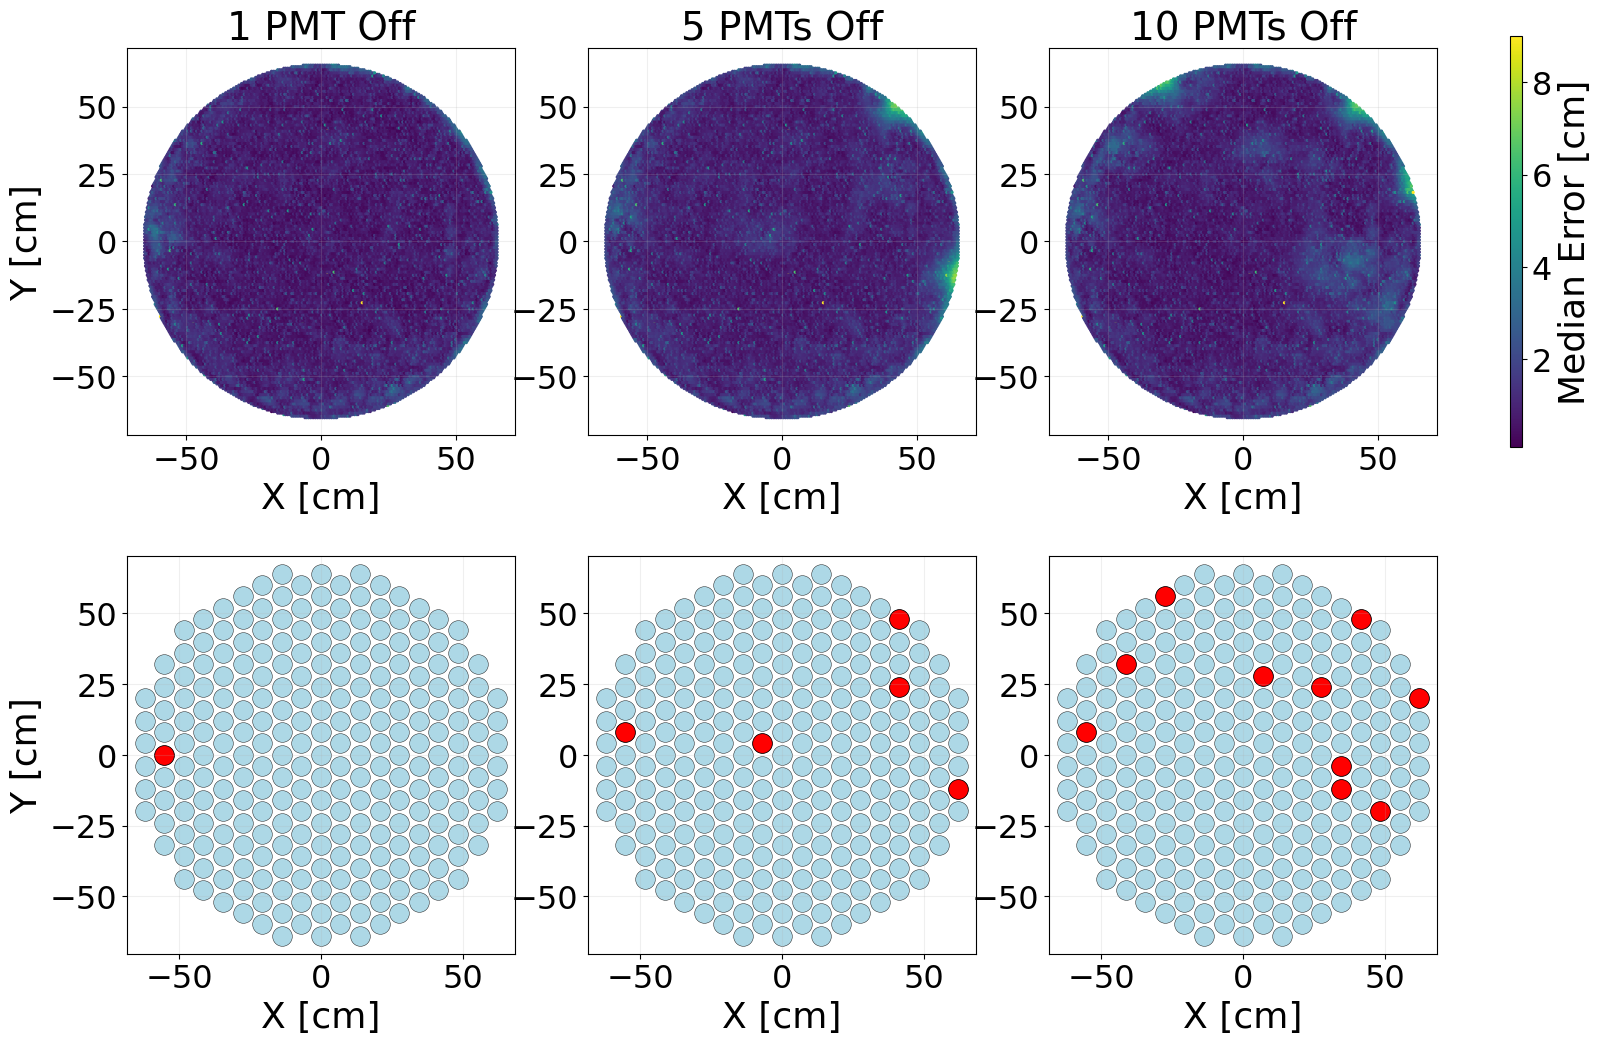

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

# --- Font size setup to match reference layout ---
plt.rcParams.update({
    "font.size": 26,
    "axes.labelsize": 26,
    "axes.titlesize": 28,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 26
})

# --- Configuration ---
gridsize = 200
vmax = 9
area_key = "area_10_1e5"
variants = ["off_1", "off_5", "off_10"]
titles = ["1 PMT Off", "5 PMTs Off", "10 PMTs Off"]

# --- Load PMT positions ---
hex_data = np.load("hex_pattern_data.npz", allow_pickle=True)
pmt_xy_top = hex_data["pmt_xy_top"]
pmt_x_top = np.array(pmt_xy_top["x"])
pmt_y_top = np.array(pmt_xy_top["y"])

# --- Load missing PMT indices ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
analysis_file = "saved_data_ungrouped_analysis.npz"
missing_pmt_sets = {}
with np.load(os.path.join(data_dir, analysis_file)) as data:
    for n_off in [1, 5, 10]:
        key = f"pmts_off_{n_off}"
        if key in data:
            missing_pmt_sets[n_off] = data[key]
        else:
            print(f"Key '{key}' not found in file.")

# --- Create figure and gridspec with space for colorbar on top row only ---
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.03], wspace=0.25, hspace=0.25)

# --- Axes for top and bottom rows ---
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]  # top row (hexbin)
axes += [fig.add_subplot(gs[1, i]) for i in range(3)]  # bottom row (PMT layout)
cax = fig.add_subplot(gs[0, 3])  # colorbar only on top row

# --- Top row: hexbin plots ---
for ax, variant, title in zip(axes[:3], variants, titles):
    key = f"{variant}_{area_key}"
    result = all_results[key]
    x = result["pos_test"][:, 0]
    y = result["pos_test"][:, 1]
    values = result["abs_errors"]

    hb = ax.hexbin(
        x, y,
        C=values,
        reduce_C_function=np.median,
        gridsize=gridsize,
        cmap='viridis',
        mincnt=1,
        vmax=vmax
    )

    ax.set_title(title)
    ax.set_xlabel("X [cm]")
    if ax is axes[0]:
        ax.set_ylabel("Y [cm]")
    ax.set_aspect("equal")
    ax.grid(alpha=0.2)

# --- Bottom row: PMT layouts ---
for ax, variant, title in zip(axes[3:], variants, titles):
    n_off = int(variant.split("_")[1])
    highlighted_pmts = missing_pmt_sets.get(n_off, [])

    ax.scatter(pmt_x_top, pmt_y_top, c='lightblue', marker='o', s=200, edgecolors='k', linewidth=0.3)
    ax.scatter(pmt_x_top[highlighted_pmts], pmt_y_top[highlighted_pmts], c='red', marker='o', s=200, edgecolors='k', linewidth=0.5)

    #for i, (x, y) in enumerate(zip(pmt_x_top, pmt_y_top)):
     #   ax.text(x, y, str(i), fontsize=9, ha='center', va='center', color='black')

    #ax.set_title(f"PMTs Off – {title}")
    ax.set_xlabel("X [cm]")
    if ax is axes[3]:
        ax.set_ylabel("Y [cm]")
    ax.set_aspect("equal")
    ax.grid(alpha=0.2)

# --- Colorbar only for top row ---
cbar = fig.colorbar(hb, cax=cax)
cbar.set_label("Median Error [cm]")

# --- Main title ---
#fig.suptitle("PMT Failure Scenarios – Hexbin Error Maps and PMT Layouts", fontsize=18)

# --- Save or Show ---
#plt.savefig("ungrouped_pmts_off_2x3_combined.png", dpi=300)
plt.show()


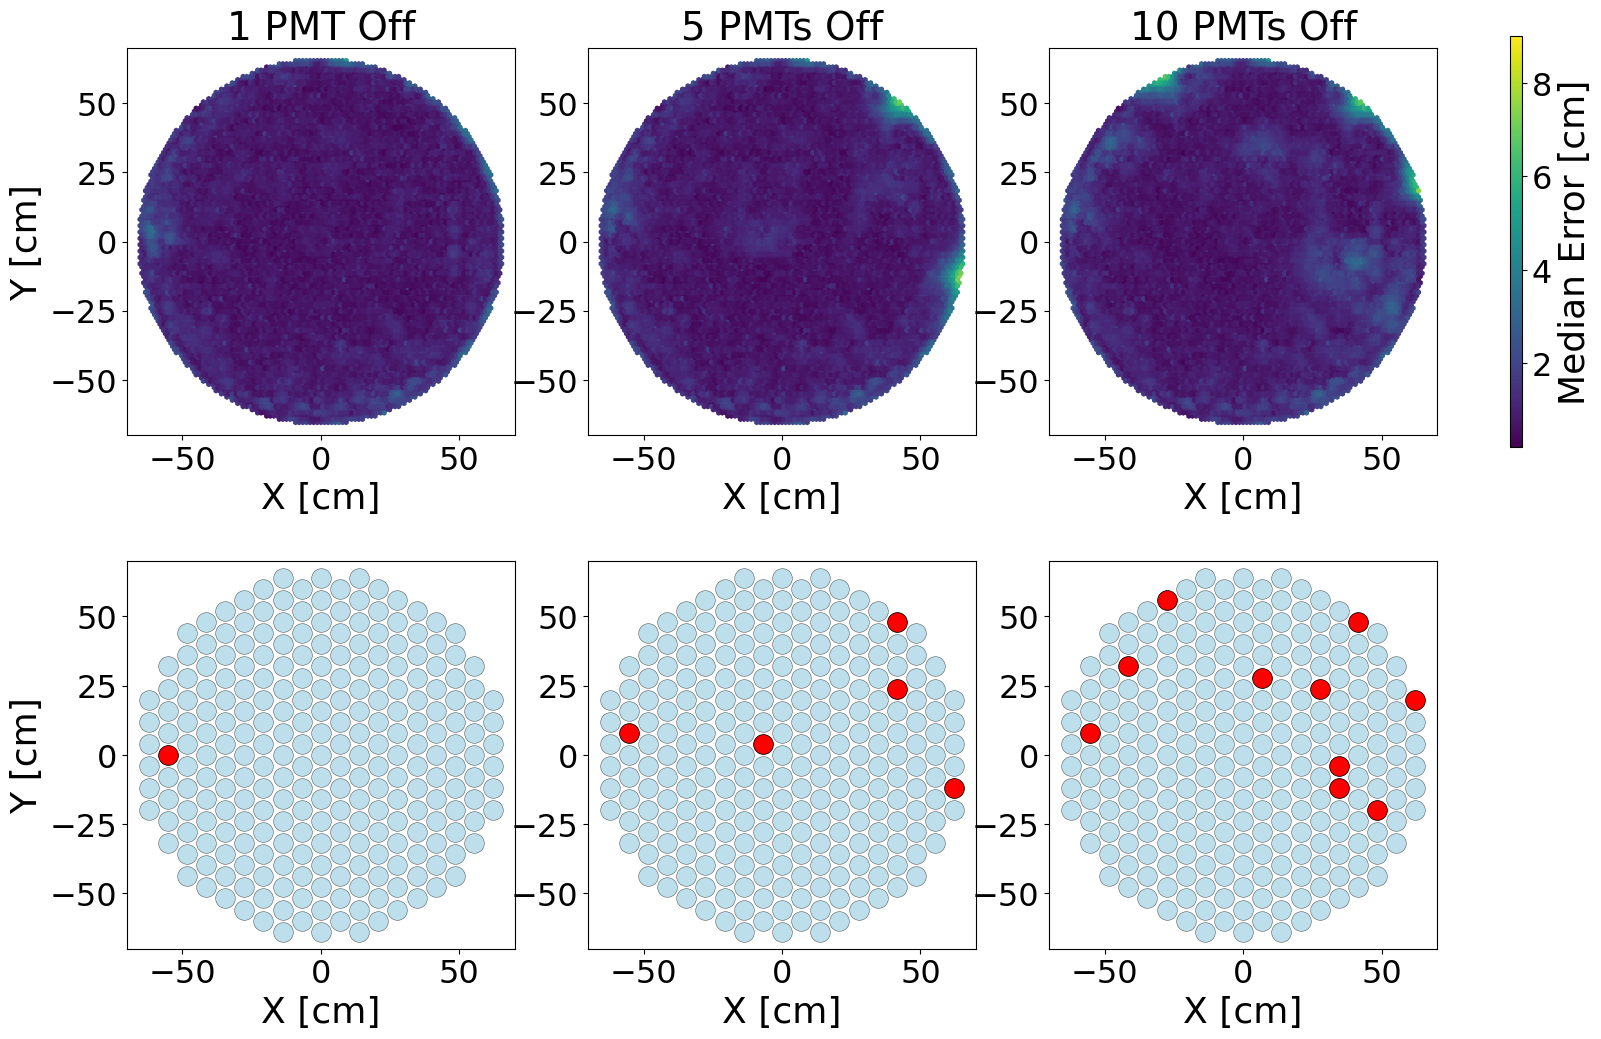

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

# --- Font size setup to match reference layout ---
plt.rcParams.update({
    "font.size": 26,
    "axes.labelsize": 26,
    "axes.titlesize": 28,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 26
})

# --- Configuration ---
gridsize = 100
vmax = 9
area_key = "area_10_1e5"
variants = ["off_1", "off_5", "off_10"]
titles = ["1 PMT Off", "5 PMTs Off", "10 PMTs Off"]
xy_limit = 70  # Apply to both x and y for all subplots

# --- Load PMT positions ---
hex_data = np.load("hex_pattern_data.npz", allow_pickle=True)
pmt_xy_top = hex_data["pmt_xy_top"]
pmt_x_top = np.array(pmt_xy_top["x"])
pmt_y_top = np.array(pmt_xy_top["y"])

# --- Load missing PMT indices ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
analysis_file = "saved_data_ungrouped_analysis.npz"
missing_pmt_sets = {}
with np.load(os.path.join(data_dir, analysis_file)) as data:
    for n_off in [1, 5, 10]:
        key = f"pmts_off_{n_off}"
        if key in data:
            missing_pmt_sets[n_off] = data[key]
        else:
            print(f"Key '{key}' not found in file.")

# --- Figure layout ---
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.03], wspace=0.25, hspace=0.25)

# --- Axes for top and bottom rows ---
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
axes += [fig.add_subplot(gs[1, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])  # colorbar only on top row

# --- Top row: hexbin error maps ---
for ax, variant, title in zip(axes[:3], variants, titles):
    key = f"{variant}_{area_key}"
    result = all_results[key]
    x = result["pos_test"][:, 0]
    y = result["pos_test"][:, 1]
    values = result["abs_errors"]

    hb = ax.hexbin(
        x, y,
        C=values,
        reduce_C_function=np.median,
        gridsize=gridsize,
        cmap='viridis',
        mincnt=1,
        vmax=vmax
    )

    ax.set_title(title)
    ax.set_xlabel("X [cm]")
    if ax is axes[0]:
        ax.set_ylabel("Y [cm]")
    ax.set_xlim(-xy_limit, xy_limit)
    ax.set_ylim(-xy_limit, xy_limit)
    ax.set_aspect("equal")
    #ax.grid(alpha=0.2)

# --- Bottom row: PMT layout plots ---
for ax, variant, title in zip(axes[3:], variants, titles):
    n_off = int(variant.split("_")[1])
    highlighted_pmts = missing_pmt_sets.get(n_off, [])

    ax.scatter(pmt_x_top, pmt_y_top, c='lightblue', marker='o', s=200, edgecolors='k', linewidth=0.3, alpha=0.8)
    ax.scatter(pmt_x_top[highlighted_pmts], pmt_y_top[highlighted_pmts],
               c='red', marker='o', s=200, edgecolors='k', linewidth=0.5)

    #for i, (x, y) in enumerate(zip(pmt_x_top, pmt_y_top)):
     #   ax.text(x, y, str(i), fontsize=9, ha='center', va='center', color='black')

    #ax.set_title(f"PMTs Off – {title}")
    ax.set_xlabel("X [cm]")
    if ax is axes[3]:
        ax.set_ylabel("Y [cm]")
    ax.set_xlim(-xy_limit, xy_limit)
    ax.set_ylim(-xy_limit, xy_limit)
    ax.set_aspect("equal")
    #ax.grid(alpha=0.2)

# --- Shared colorbar for hexbin plots only ---
cbar = fig.colorbar(hb, cax=cax)
cbar.set_label("Median Error [cm]")

# --- Main title ---
#fig.suptitle("PMT Failure Scenarios – Hexbin Error Maps and PMT Layouts", fontsize=18)

# --- Save or Show ---
#plt.savefig("ungrouped_pmts_off_2x3_uniform_axes.png", dpi=300)
plt.show()
